In [1]:
# ─── Import Required Libraries ────────────────────────────────────────────────
import numpy as np                          # For numerical operations and arrays
import matplotlib.pyplot as plt             # For plotting jet images or distributions
from pathlib import Path                    # For handling file system paths
import h5py                                 # For reading HDF5 jet data files
from matplotlib.colors import LogNorm       # For log-scale image normalization
from tqdm import tqdm                       # For progress bars during batch processing
import time                                 # For measuring execution time

# ─── Define File Paths ────────────────────────────────────────────────────────

# Path to the saved HDF5 file containing full jet and constituent-level data
jet_data_path = Path("/home/soumodip/Python/MSc_Project/Finalized_Project/Training_data_75k_100GeV/Tau_Pipeline/Tau_Datas/jet_data_tau.h5")

# Output path for saving processed full jet image .npy files (for CNN input)
full_jet_npy_file_path = Path("/home/soumodip/Python/MSc_Project/Finalized_Project/Training_data_75k_100GeV/Tau_Pipeline/npy_Files_Tau/Full_jet_npy_files")

# Output path for saving processed core jet image .npy files (focused on high-pT region)
core_jet_npy_file_path = Path("/home/soumodip/Python/MSc_Project/Finalized_Project/Training_data_75k_100GeV/Tau_Pipeline/npy_Files_Tau/Core_jet_npy_files")

In [2]:
# ─── Jet Image Grid Parameters ─────────────────────────────────────────────────

a = 0.8               # Half-width of full jet image region in η–φ space
b = 0.2               # Half-width of core jet region (focused on jet center)
jet_core_r = 0.15     # Radius used to extract core region from full jet

# ─── Pixel Size and Grid Resolution ────────────────────────────────────────────
pixel_dim_full = 0.05                         # Pixel width for full jet image
grids_full = int(round((2 * a) / pixel_dim_full))  # Number of pixels in full jet grid (40x40)

pixel_dim_core = 0.02                         # Pixel width for core jet image
grids_core = int(round((2 * b) / pixel_dim_core))  # Number of pixels in core jet grid (20x20)

# ─── Jet Image Ranges in η and φ ──────────────────────────────────────────────
eta_range_full = (-a, a)       # η range for full jet image
eta_range_core = (-b, b)       # η range for core jet image
phi_range_full = (-a, a)       # φ range for full jet image
phi_range_core = (-b, b)       # φ range for core jet image

# ─── Image Preprocessing Settings ─────────────────────────────────────────────
normalize_intensity = True     # Whether to normalize pixel intensities per image

# ─── Batch Size for Processing ────────────────────────────────────────────────
BATCH_SIZE = 10000             # Number of jets processed per batch

# ─── Label Mapping for Jet Tags ───────────────────────────────────────────────
tag_to_label = {
    "tau": 0,         # Label 0 for τ
    "antitau": 1,     # Label 1 for anti-τ
    "unmatched": 2    # Label 2 for unmatched jets (optional class or ignored)
}

In [3]:
def center_jet(constituents):
    """
    Center the jet constituents in the η–φ plane using pT-weighted centroid.

    Args:
        constituents (np.ndarray): Array of shape (N, 6) with columns 
                                   [E, pT, η, φ, charge, pdg_id]

    Returns:
        np.ndarray: Updated array with centered η and φ values
    """

    # ─── Extract pT, η, and φ components ───────────────────────────────────────
    pt  = constituents[:, 1]
    eta = constituents[:, 2]
    phi = constituents[:, 3]
    
    # ─── Compute pT-weighted centroid ─────────────────────────────────────────
    total_pt = np.sum(pt)
    eta_centroid = np.sum(pt * eta) / total_pt
    phi_centroid = np.sum(pt * phi) / total_pt

    # ─── Center η and φ around the centroid ───────────────────────────────────
    centered_eta = eta - eta_centroid
    centered_phi = phi - phi_centroid

    # Wrap φ into [−π, π] range to handle circularity
    centered_phi = np.arctan2(np.sin(centered_phi), np.cos(centered_phi))
    
    # ─── Return Updated Constituents ──────────────────────────────────────────
    centered_constituents = constituents.copy()
    centered_constituents[:, 2] = centered_eta
    centered_constituents[:, 3] = centered_phi
    
    return centered_constituents

In [4]:
def rotate_jet(constituents):
    """
    Rotate jet in the η–φ plane so that the second-leading pT constituent lies along the η-axis.

    Args:
        constituents (np.ndarray): Array of shape (N, 6) with columns 
                                   [E, pT, η, φ, charge, pdg_id]

    Returns:
        np.ndarray: Updated array with rotated η and φ values
    """

    # ─── Extract Relevant Columns ─────────────────────────────────────────────
    pt  = constituents[:, 1]
    eta = constituents[:, 2]
    phi = constituents[:, 3]

    # ─── Sort Constituents by Descending pT ───────────────────────────────────
    sorted_indices = np.argsort(pt)[::-1]

    # If fewer than 2 constituents, skip rotation
    if len(sorted_indices) < 2:
        return constituents

    # ─── Use Second-Highest pT Constituent as Rotation Reference ──────────────
    second_eta = eta[sorted_indices[1]]
    second_phi = phi[sorted_indices[1]]

    # Calculate rotation angle to align it with the η-axis
    theta = np.arctan2(second_phi, second_eta)

    # ─── Perform Rotation in η–φ Plane ────────────────────────────────────────
    rotated_eta = eta * np.cos(-theta) - phi * np.sin(-theta)
    rotated_phi = eta * np.sin(-theta) + phi * np.cos(-theta)

    # ─── Return Updated Constituents ─────────────────────────────────────────
    rotated_constituents = constituents.copy()
    rotated_constituents[:, 2] = rotated_eta
    rotated_constituents[:, 3] = rotated_phi

    return rotated_constituents

In [5]:
def create_jet_image(constituents, grid_size, eta_range, phi_range, normalize=True):
    """
    Create a jet image by binning constituent pT values into a 2D histogram over (η, φ) space.

    Args:
        constituents (np.ndarray): Array with shape (N, 6), including [E, pT, η, φ, charge, pdg_id]
        grid_size (int): Number of pixels along each axis (e.g., 40 for a 40×40 image)
        eta_range (tuple): (min_eta, max_eta) for the image grid
        phi_range (tuple): (min_phi, max_phi) for the image grid
        normalize (bool): Whether to normalize the total intensity to 1

    Returns:
        np.ndarray: 2D jet image of shape (grid_size, grid_size)
    """
    pt  = constituents[:, 1]
    eta = constituents[:, 2]
    phi = constituents[:, 3]
    
    # Create 2D histogram (η × φ grid) weighted by pT
    image, _, _ = np.histogram2d(
        eta, phi,
        bins=[np.linspace(*eta_range, grid_size + 1), np.linspace(*phi_range, grid_size + 1)],
        weights=pt)

    # Normalize image intensity (total sum = 1)
    if normalize and np.sum(image) > 0:
        image = image / np.sum(image)
    
    return image

In [6]:
def plot_sample_images(images, labels, label_mapping, eta_range, phi_range, num_samples):
    """
    Plot sample jet images for each class label.

    Args:
        images (np.ndarray): Array of jet images with shape (N, H, W)
        labels (np.ndarray): Array of integer labels (e.g., 0 = tau, 1 = antitau, etc.)
        label_mapping (dict): Mapping from tag string (e.g., "tau") to label int
        eta_range (tuple): (min_eta, max_eta) for image extent
        phi_range (tuple): (min_phi, max_phi) for image extent
        num_samples (int): Number of images to plot per class
    """
    
    unique_labels = np.unique(labels)  # Identify all unique classes

    for label in unique_labels:
        label_indices = np.where(labels == label)[0]  # Get indices of current class
        if len(label_indices) == 0:
            continue  # Skip if no jets of this class

        # Create subplot for selected samples of this class
        fig, axs = plt.subplots(1, min(num_samples, len(label_indices)),
                                figsize=(5 * num_samples, 5),
                                constrained_layout=True)
        axs = np.atleast_1d(axs)  # Ensure axs is always an iterable (even if 1 plot)

        # Plot each image with log-normalized color scale
        for idx, ax in zip(label_indices[:num_samples], axs):
            im = ax.imshow(images[idx], origin='lower',
               extent=[eta_range[0], eta_range[1], phi_range[0], phi_range[1]],
               cmap='jet', aspect='equal', norm=LogNorm(vmin=1e-3, vmax=1))

            # Get label name from mapping
            tag_name = [k for k, v in label_mapping.items() if v == label][0]
            ax.set_title(f"{tag_name.capitalize()} Jet", fontsize=12)

            # Axes labels and ticks
            ax.set_xlabel(r'$\Delta \eta$', fontsize=10)
            ax.set_ylabel(r'$\Delta \phi$', fontsize=10)
            ax.set_xticks(np.linspace(eta_range[0], eta_range[1], 5))
            ax.set_yticks(np.linspace(phi_range[0], phi_range[1], 5))

            # Colorbar for pT scale
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label(r'$p_{T}$ (GeV)', fontsize=10)
            cbar.ax.tick_params(labelsize=8)
            ax.tick_params(labelsize=10)

        plt.show()


Total events in dataset: 71415

Processing batch: Events 0 to 9999


Batch 0: 100%|███████████████████████████| 10000/10000 [00:23<00:00, 418.90it/s]


Saved batch 0-9999: 17596 images
Time taken: 24.01 seconds



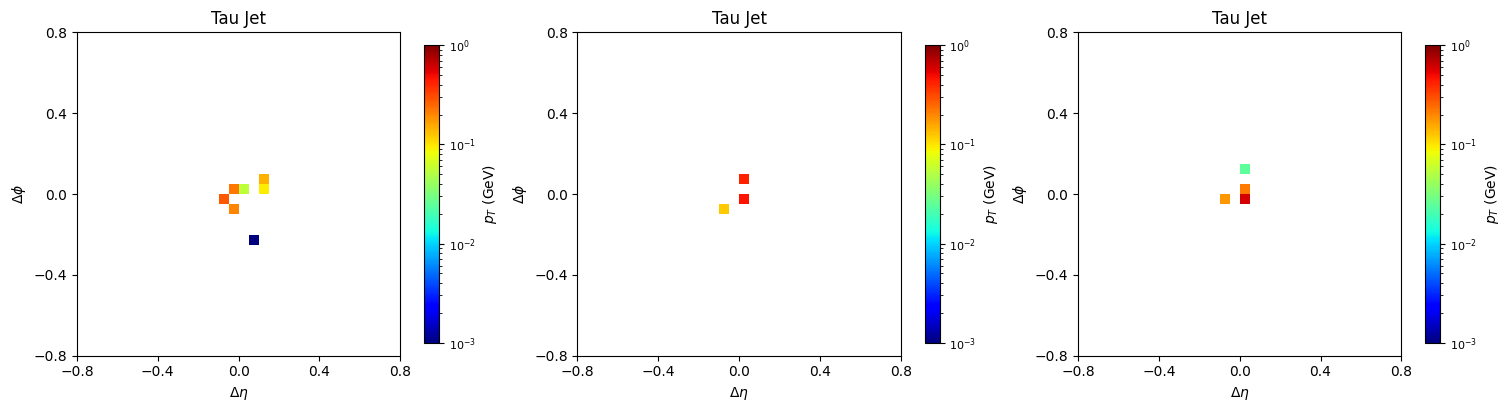

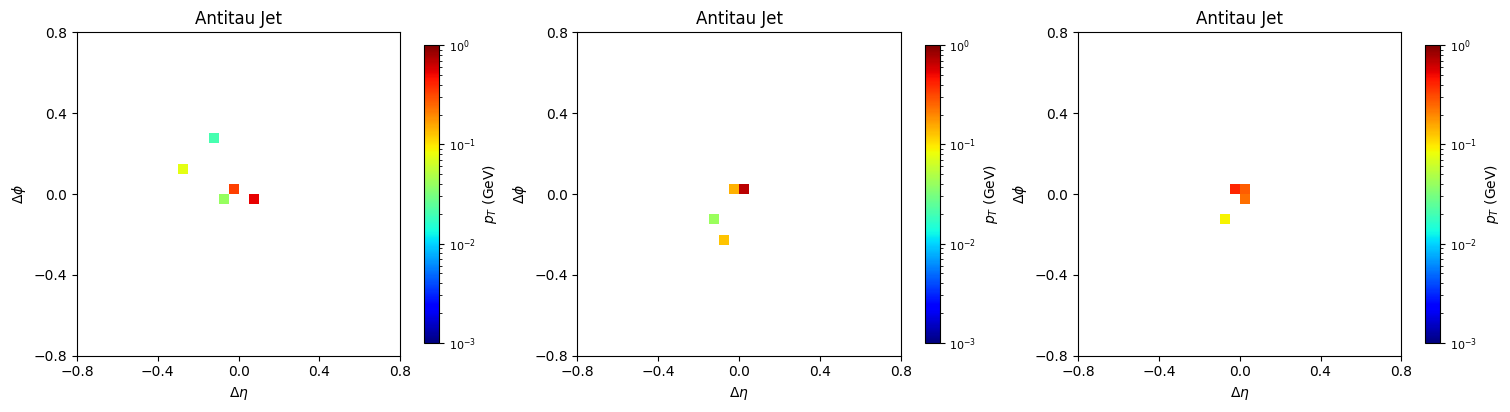

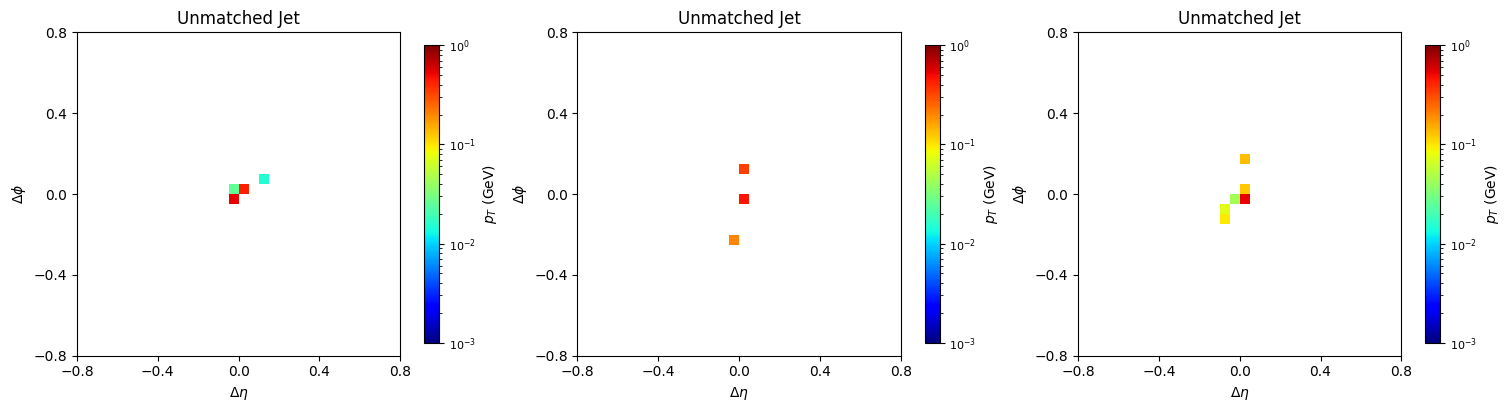


Processing batch: Events 10000 to 19999


Batch 10000: 100%|███████████████████████| 10000/10000 [00:23<00:00, 423.11it/s]


Saved batch 10000-19999: 17528 images
Time taken: 23.72 seconds



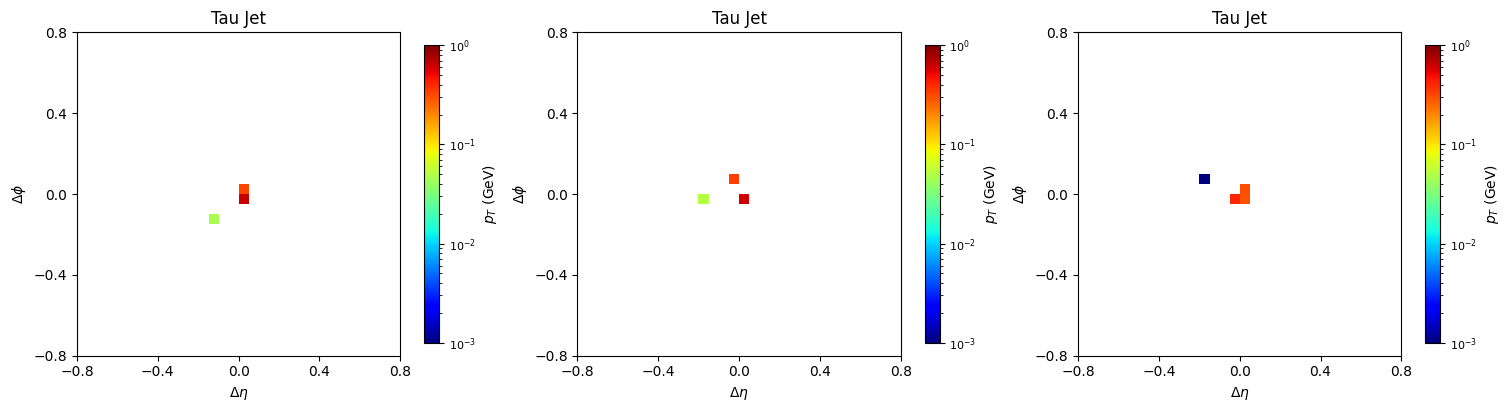

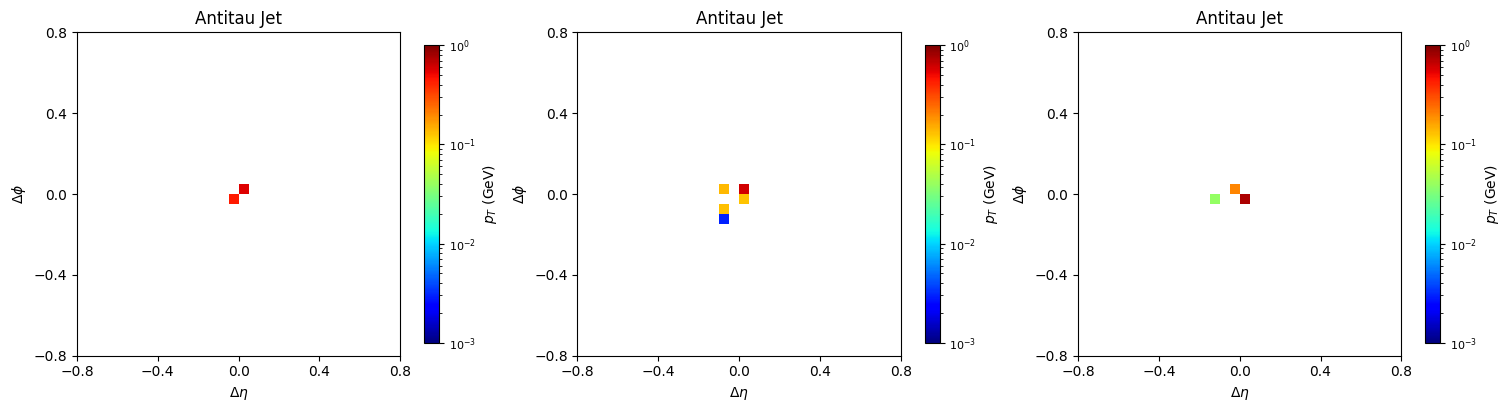

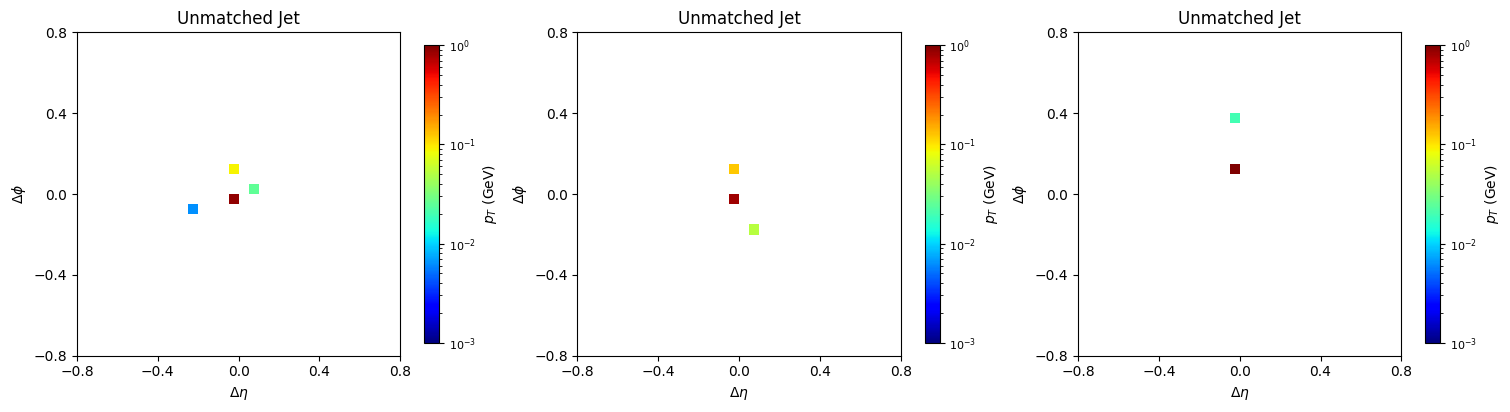


Processing batch: Events 20000 to 29999


Batch 20000: 100%|███████████████████████| 10000/10000 [00:23<00:00, 427.68it/s]


Saved batch 20000-29999: 17527 images
Time taken: 23.49 seconds



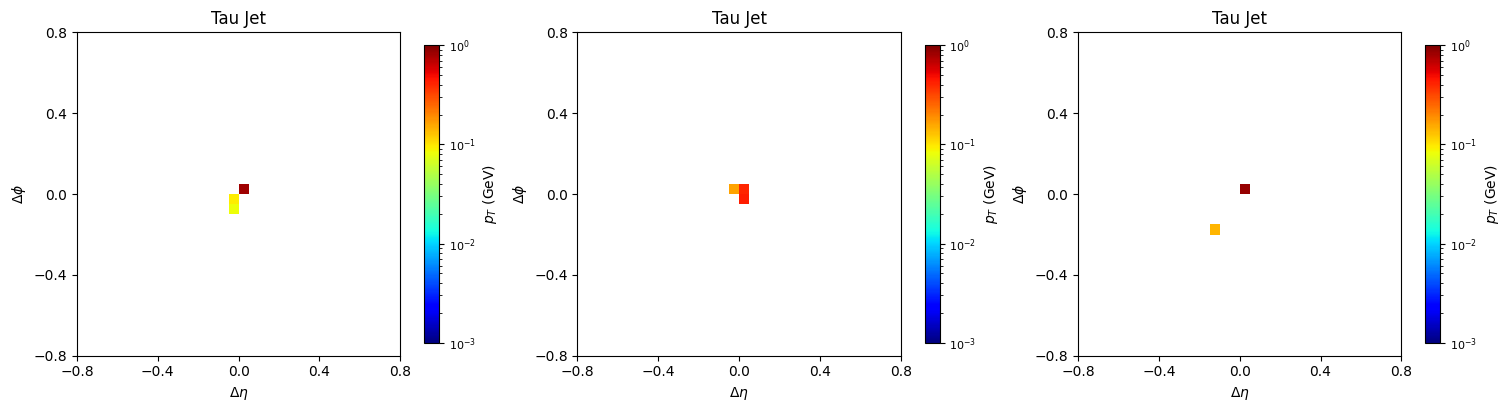

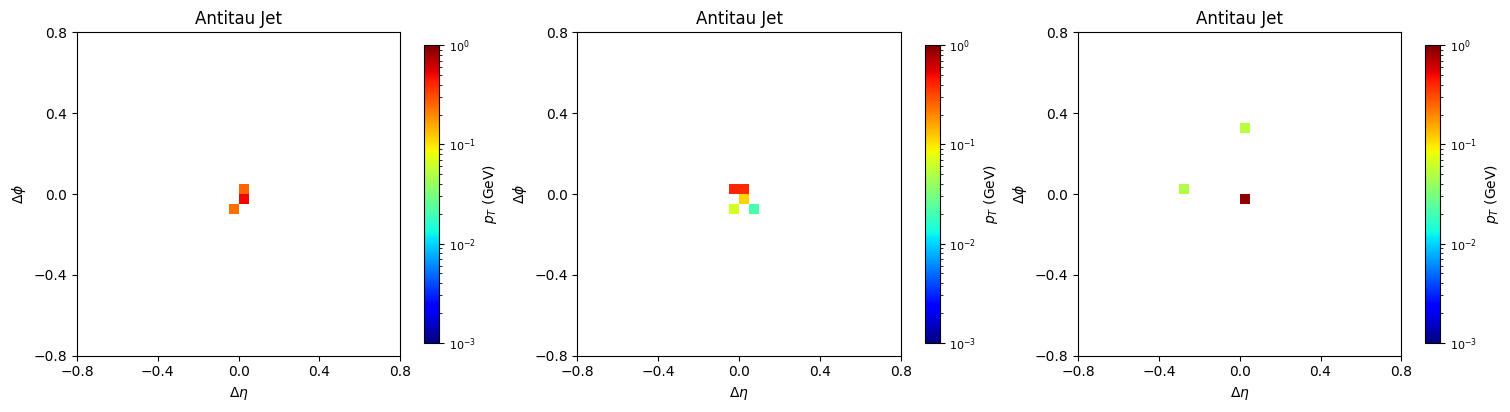

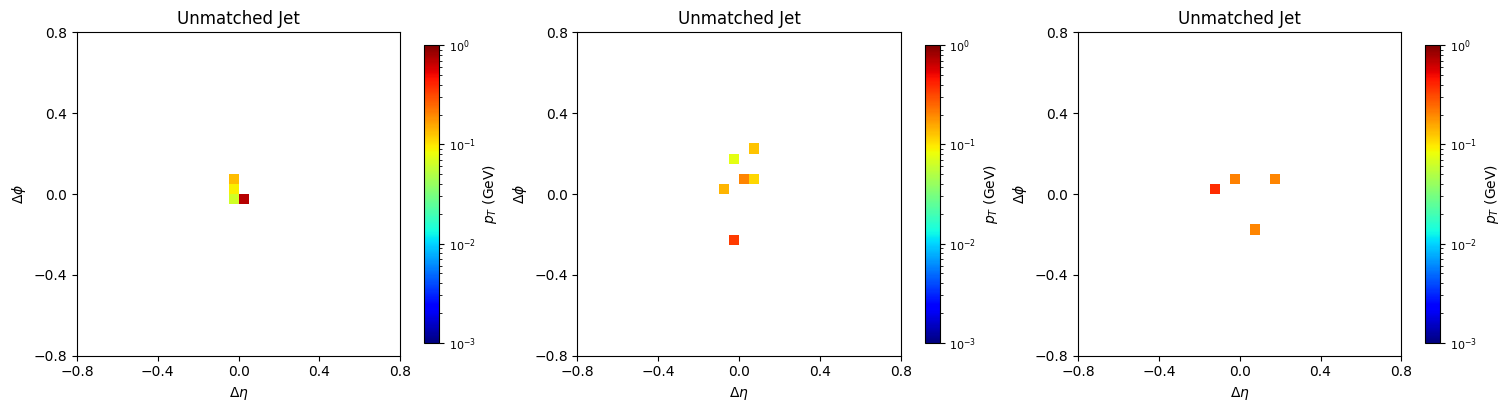


Processing batch: Events 30000 to 39999


Batch 30000: 100%|███████████████████████| 10000/10000 [00:23<00:00, 425.18it/s]


Saved batch 30000-39999: 17426 images
Time taken: 23.61 seconds



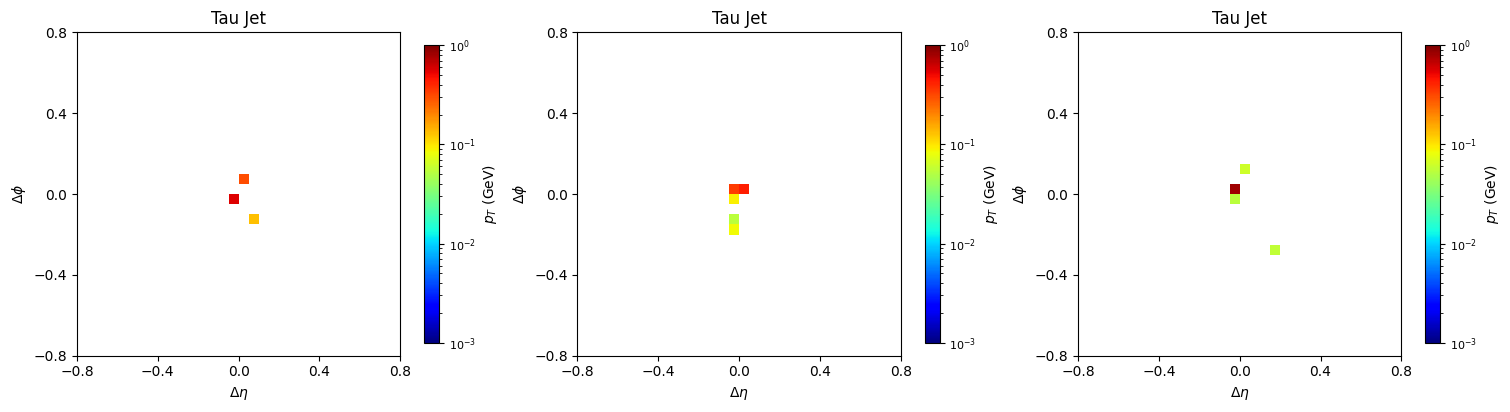

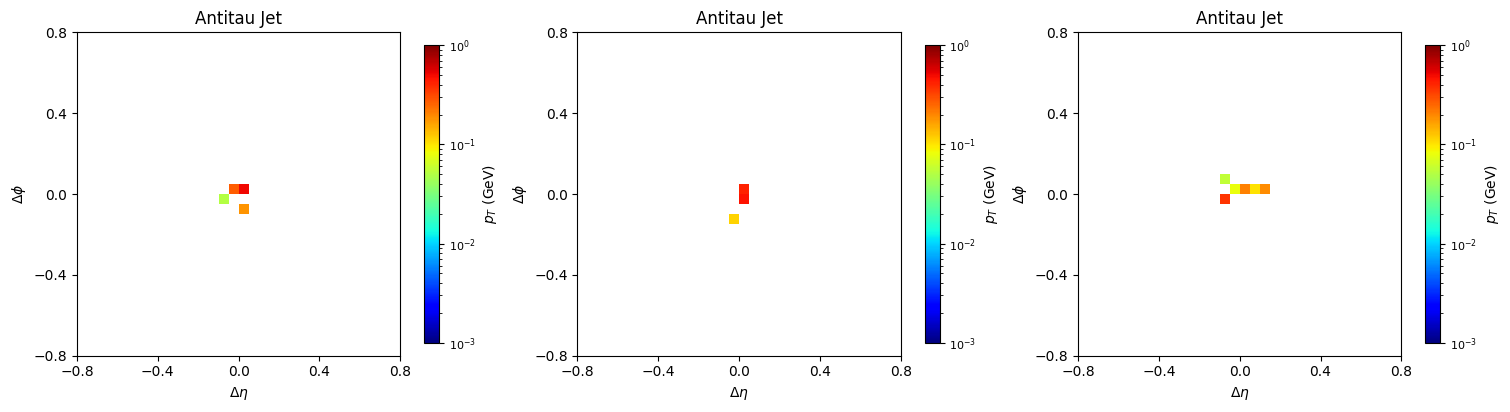

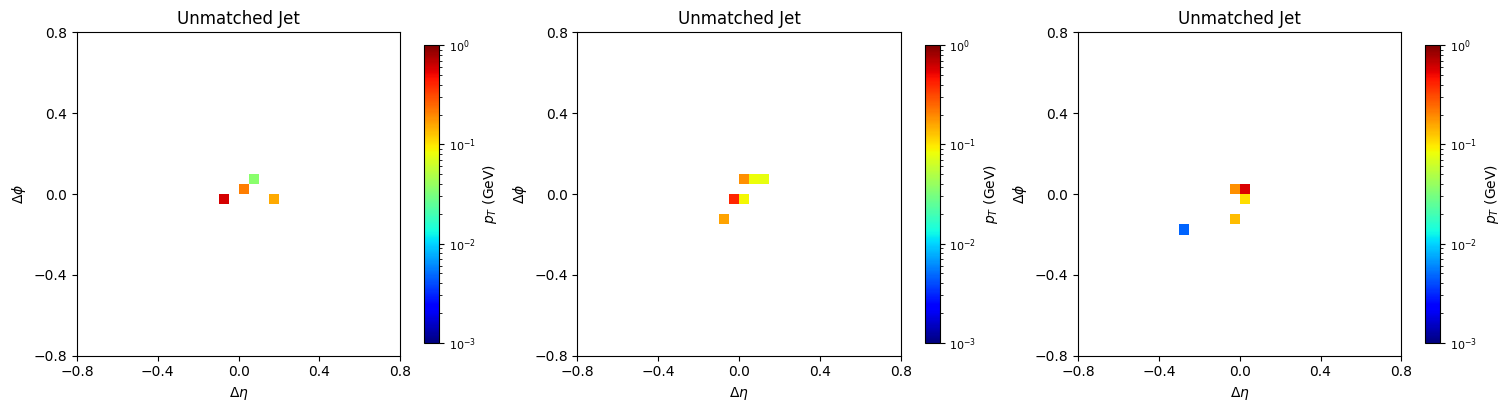


Processing batch: Events 40000 to 49999


Batch 40000: 100%|███████████████████████| 10000/10000 [00:23<00:00, 424.81it/s]


Saved batch 40000-49999: 17587 images
Time taken: 23.63 seconds



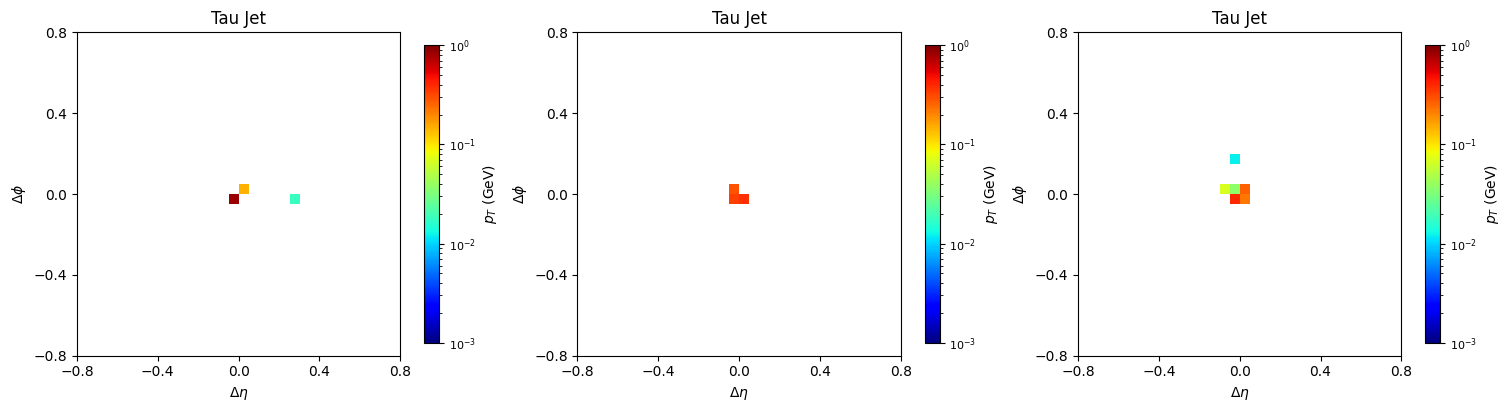

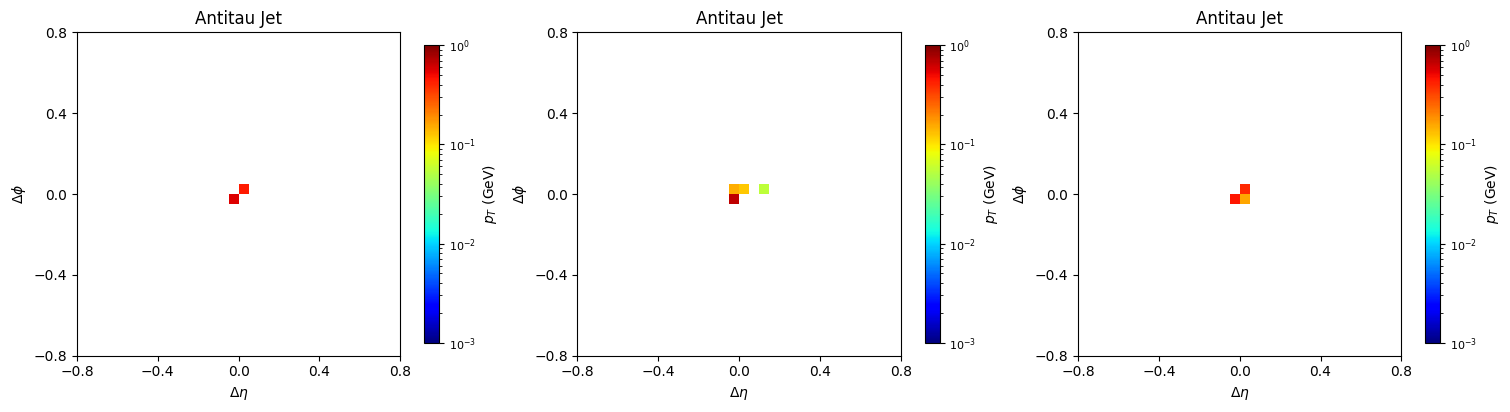

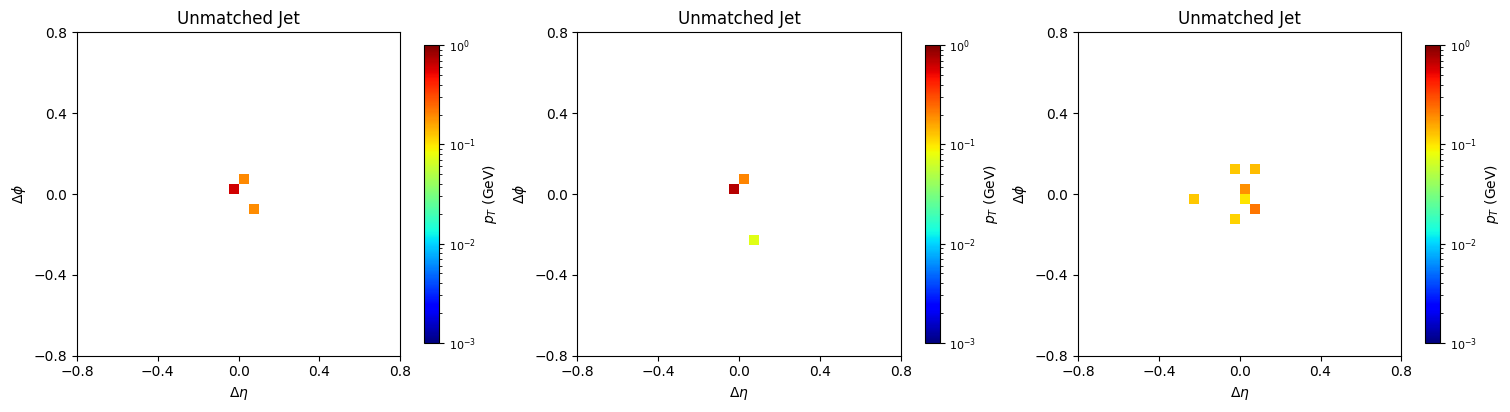


Processing batch: Events 50000 to 59999


Batch 50000: 100%|███████████████████████| 10000/10000 [00:23<00:00, 425.34it/s]


Saved batch 50000-59999: 17582 images
Time taken: 23.60 seconds



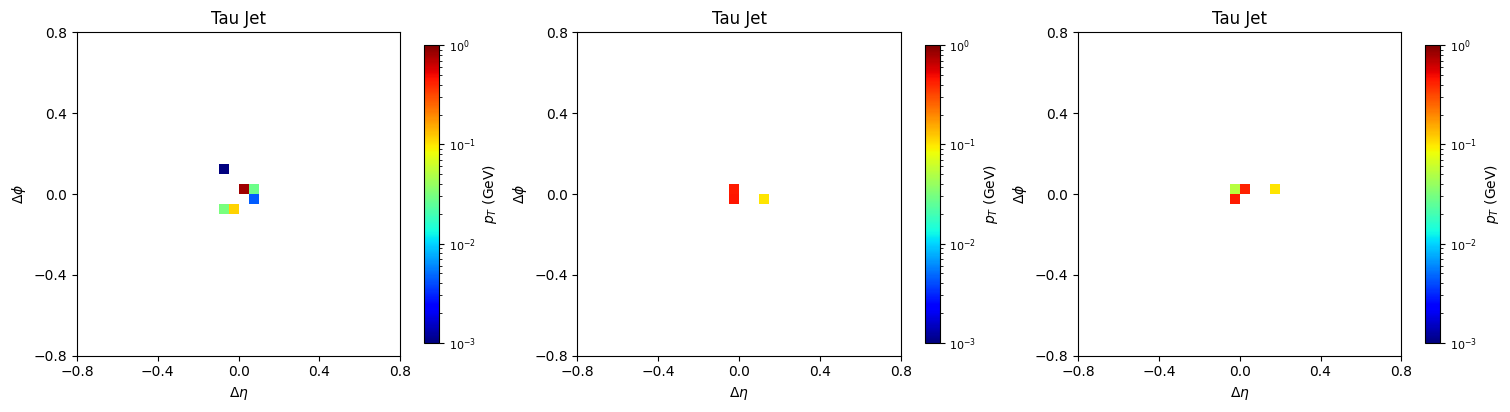

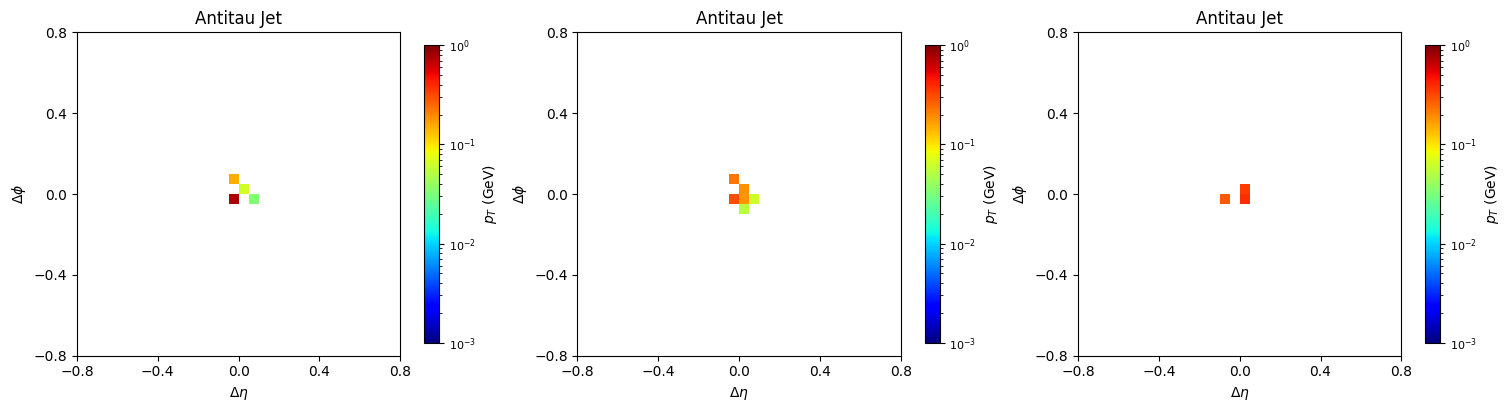

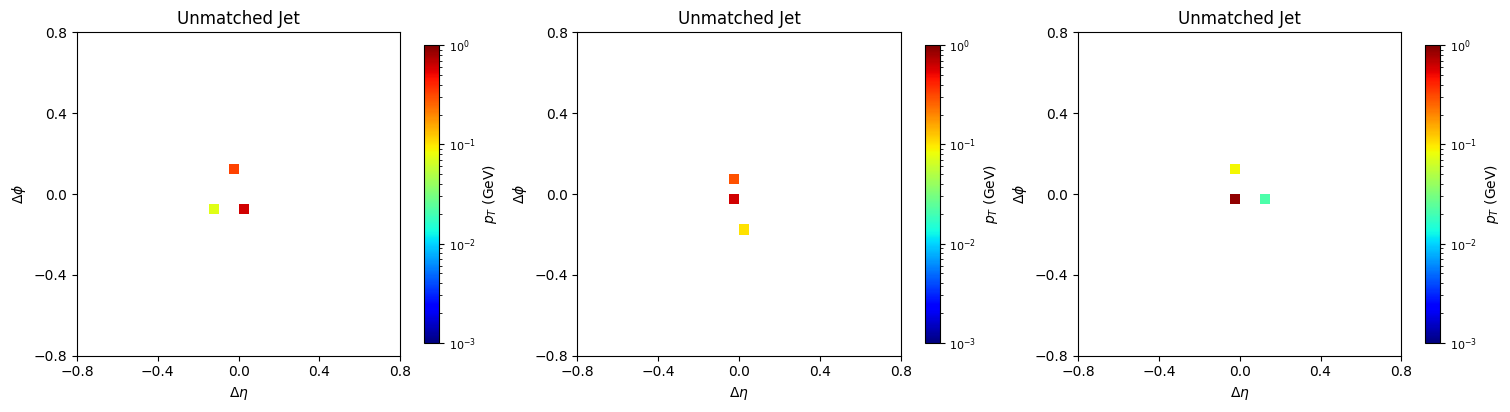


Processing batch: Events 60000 to 69999


Batch 60000: 100%|███████████████████████| 10000/10000 [00:23<00:00, 429.06it/s]


Saved batch 60000-69999: 17583 images
Time taken: 23.41 seconds



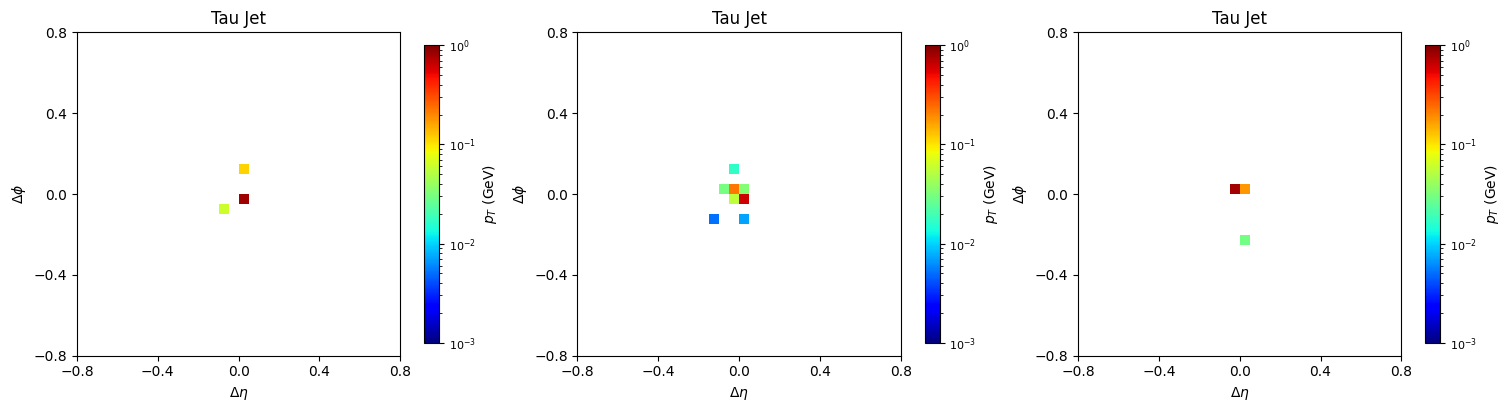

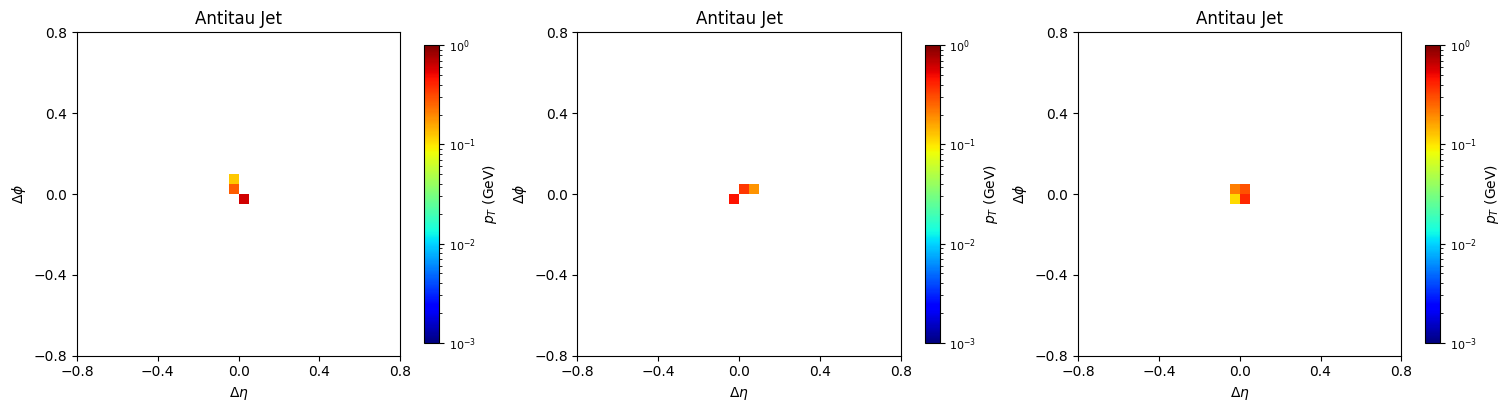

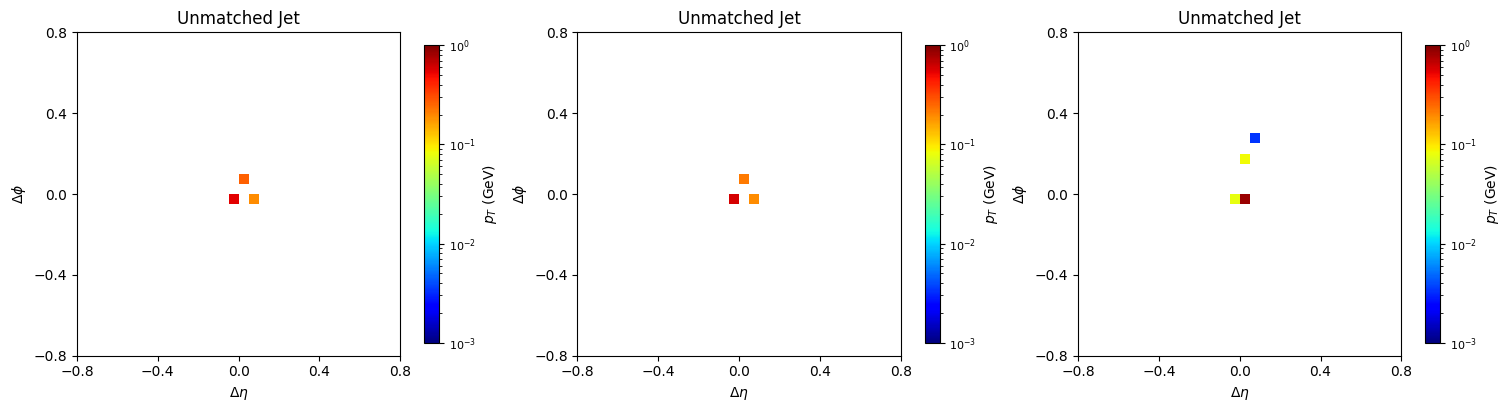


Processing batch: Events 70000 to 71414


Batch 70000: 100%|█████████████████████████| 1415/1415 [00:03<00:00, 427.78it/s]


Saved batch 70000-71414: 2464 images
Time taken: 3.33 seconds



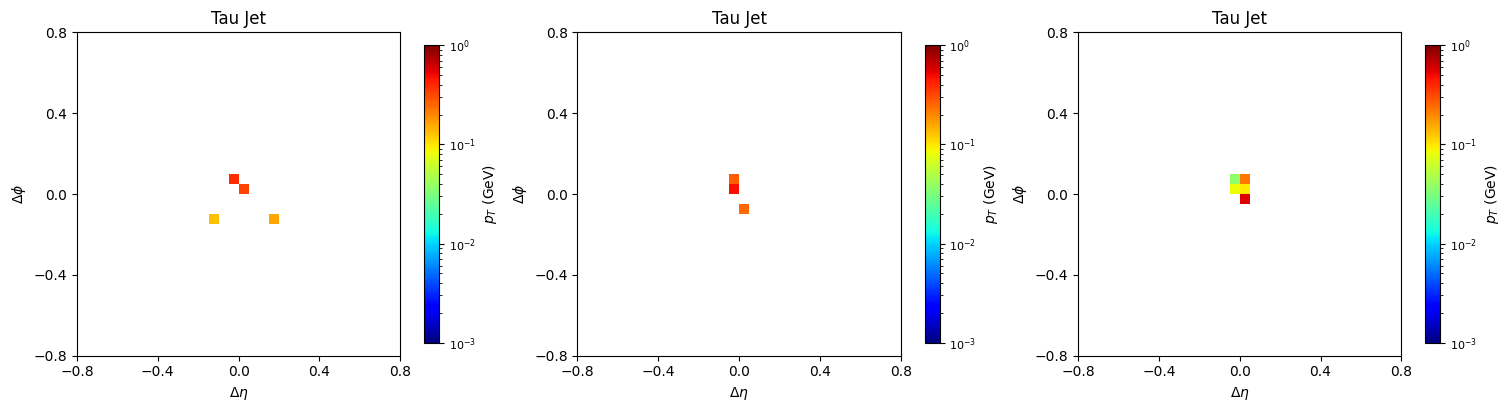

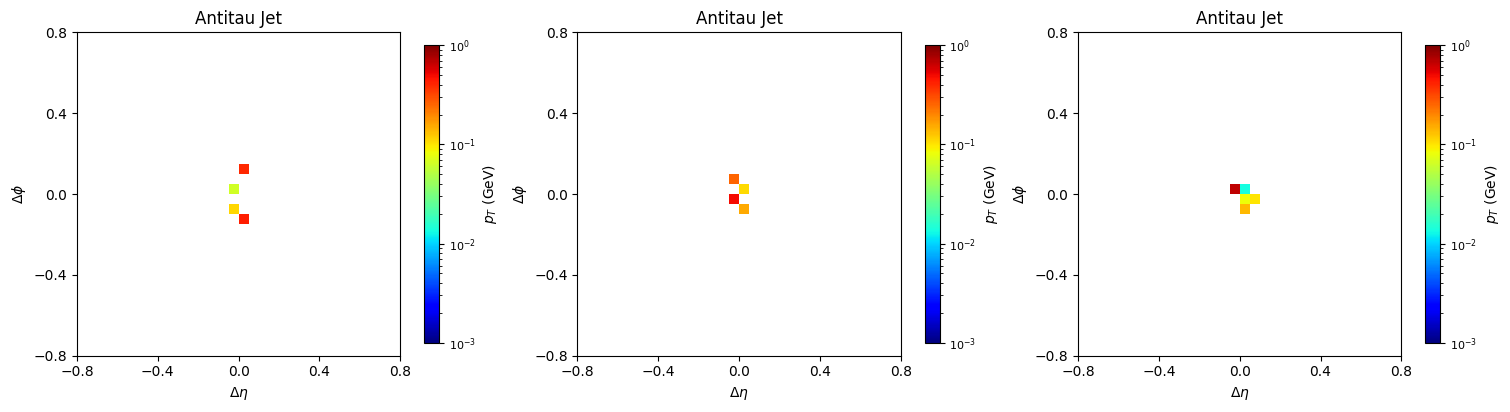

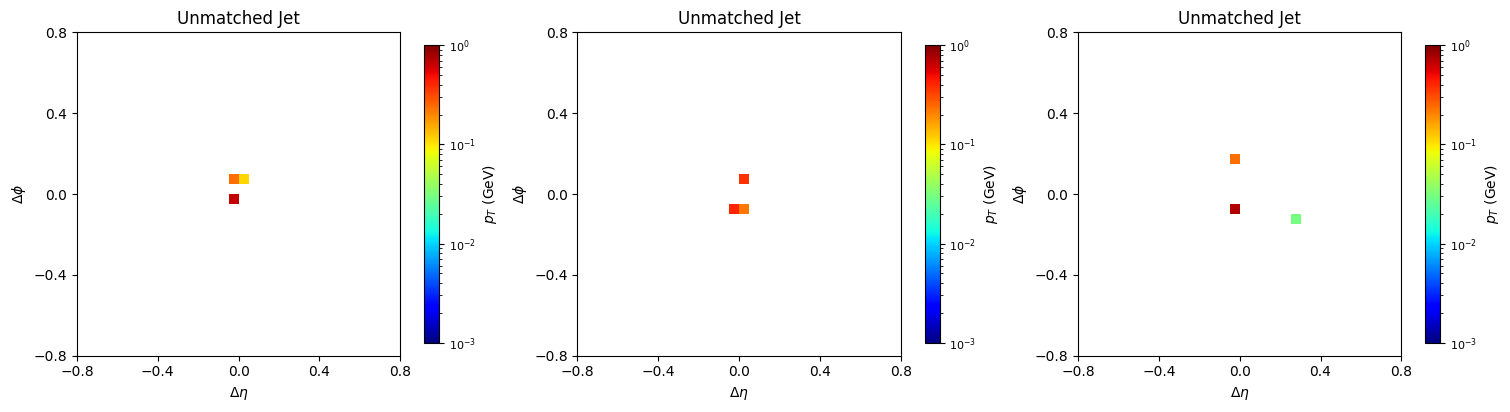

In [7]:
# ─── Read Jet Data from HDF5 and Process in Batches ────────────────────────────
with h5py.File(jet_data_path, "r") as f:
    total_events = len(f.keys())  # Total number of events in the HDF5 file
    print(f"\nTotal events in dataset: {total_events}")

    # ─── Process in Batches ───────────────────────────────────────────────────
    for batch_start in range(0, total_events, BATCH_SIZE):
        batch_end = min(batch_start + BATCH_SIZE, total_events)

        # Initialize containers for this batch
        batch_images = []
        batch_labels = []
        batch_pts = []
        batch_etas = []
        batch_phis = []
        batch_charged_mults = []

        print(f"\nProcessing batch: Events {batch_start} to {batch_end - 1}")
        batch_start_time = time.time()

        # ─── Loop Over Events in the Current Batch ────────────────────────────
        for i in tqdm(range(batch_start, batch_end), desc=f"Batch {batch_start}"):
            event = f[f"event_{i}"]
            num_jets = len(event["pt"])  # Number of jets in the event
            tags = [tag.decode('utf-8') for tag in event["tag"][:]]  # Decode string tags

            # ─── Loop Over Jets Within Each Event ─────────────────────────────
            for j in range(num_jets):
                jet_constituents = event[f"jet_{j}_constituents"][:]  # (E, pT, η, φ, charge, pdg_id)
                pt = event["pt"][j]
                eta = event["eta"][j]
                phi = event["phi"][j]
                n_charged = event["charge_multiplicity"][j]

                # ─── Preprocess Jet: Center → Rotate → Image ──────────────────
                centered = center_jet(jet_constituents)
                rotated = rotate_jet(centered)
                image = create_jet_image(
                    rotated, grids_full, eta_range_full, phi_range_full,
                    normalize=normalize_intensity
                )

                # ─── Append to Batch If Image is Valid ────────────────────────
                if np.isclose(np.sum(image), 1.0, atol=1e-3):
                    batch_images.append(image)
                    batch_labels.append(tag_to_label.get(tags[j], 2))  # Map tag to label
                    batch_pts.append(pt)
                    batch_etas.append(eta)
                    batch_phis.append(phi)
                    batch_charged_mults.append(n_charged)

        # ─── Convert to NumPy Arrays ──────────────────────────────────────────
        batch_images = np.array(batch_images, dtype=np.float32)
        batch_labels = np.array(batch_labels, dtype=np.int32)
        batch_pts = np.array(batch_pts, dtype=np.float32)
        batch_etas = np.array(batch_etas, dtype=np.float32)
        batch_phis = np.array(batch_phis, dtype=np.float32)
        batch_charged_mults = np.array(batch_charged_mults, dtype=np.int32)

        # ─── Save Batch to .npy/.npz Files ────────────────────────────────────
        np.save(full_jet_npy_file_path / f"taujet_imgs_batch_{batch_start}.npy", batch_images)
        np.save(full_jet_npy_file_path / f"taujet_lbls_batch_{batch_start}.npy", batch_labels)
        np.savez(
            full_jet_npy_file_path / f"taujet_metadata_batch_{batch_start}.npz",
            pt=batch_pts,
            eta=batch_etas,
            phi=batch_phis,
            n_charged=batch_charged_mults
        )

        # ─── Log Batch Statistics ─────────────────────────────────────────────
        batch_end_time = time.time()
        print(f"Saved batch {batch_start}-{batch_end - 1}: {batch_images.shape[0]} images")
        print(f"Time taken: {batch_end_time - batch_start_time:.2f} seconds\n")

        # ─── Optional: Plot a Few Sample Jet Images ──────────────────────────
        plot_sample_images(batch_images, batch_labels, tag_to_label,
                           eta_range_full, phi_range_full, num_samples=3)

In [8]:
def compute_core_ratios(jet_constituents, jet_pt, total_charged, core_radius):
    """
    Compute the fraction of jet pT and charged multiplicity within a core region.

    Args:
        jet_constituents (np.ndarray): Array of constituents [E, pT, η, φ, charge, pdg_id]
        jet_pt (float): Total pT of the jet
        total_charged (int): Total number of charged constituents in the jet
        core_radius (float): Radius (ΔR) defining the jet core

    Returns:
        tuple:
            - core_pt_ratio (float): pT fraction inside the core
            - core_charged_ratio (float): charged multiplicity fraction inside the core
            - core_mask (np.ndarray): Boolean mask selecting core constituents
    """

    # ─── Extract Constituent Properties ───────────────────────────────────────
    pt     = jet_constituents[:, 1]
    eta    = jet_constituents[:, 2]
    phi    = jet_constituents[:, 3]
    charge = jet_constituents[:, 4]

    # ─── Compute pT-Weighted Centroid ─────────────────────────────────────────
    eta_centroid = np.sum(pt * eta) / np.sum(pt)
    phi_centroid = np.sum(pt * phi) / np.sum(pt)

    # ─── Compute Distance from Centroid in (η, φ) Space ──────────────────────
    d_eta = eta - eta_centroid
    d_phi = np.arctan2(np.sin(phi - phi_centroid), np.cos(phi - phi_centroid))  # Wrap angle
    d_r   = np.sqrt(d_eta**2 + d_phi**2)  # ΔR distance from centroid

    # ─── Identify Core Constituents ──────────────────────────────────────────
    core_mask = d_r < core_radius

    # ─── Compute Core pT and Charged Ratios ──────────────────────────────────
    core_pt = np.sum(pt[core_mask])
    core_pt_ratio = core_pt / jet_pt if jet_pt > 0 else 0.0

    core_charged = np.count_nonzero(charge[core_mask])
    core_charged_ratio = core_charged / total_charged if total_charged > 0 else 0.0

    return core_pt_ratio, core_charged_ratio, core_mask



Total events in dataset: 71415

Processing batch: Events 0 to 9999


Batch 0: 100%|███████████████████████████| 10000/10000 [00:17<00:00, 560.61it/s]


Saved batch 0-9999 | Images: 17467 | Time: 17.90 sec


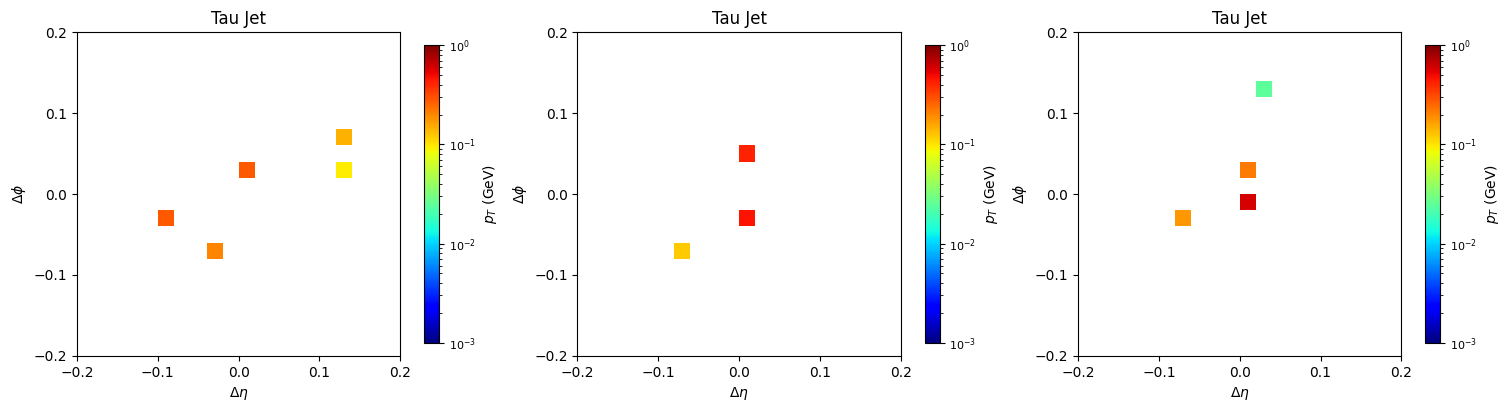

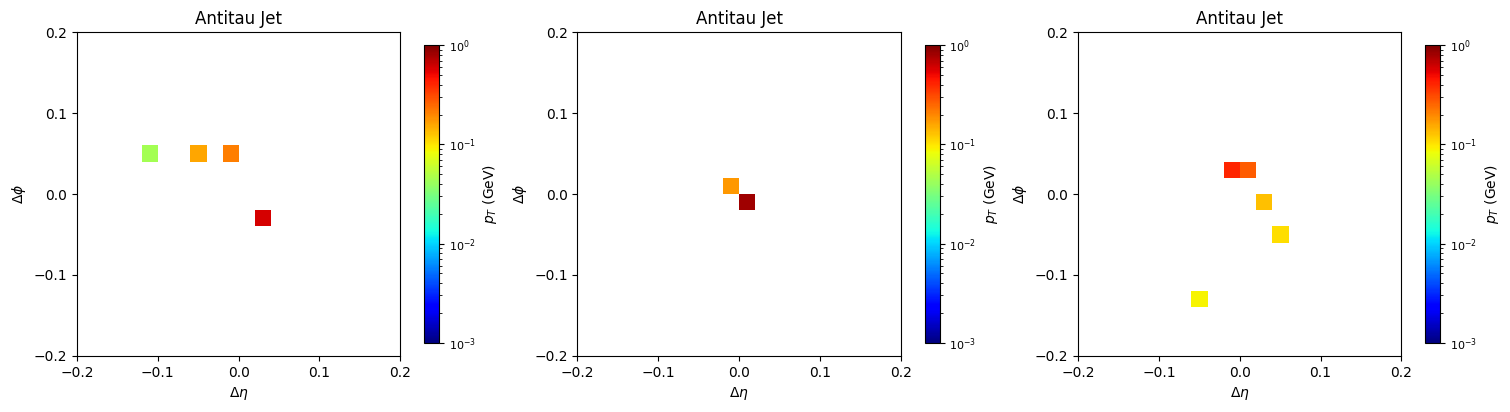

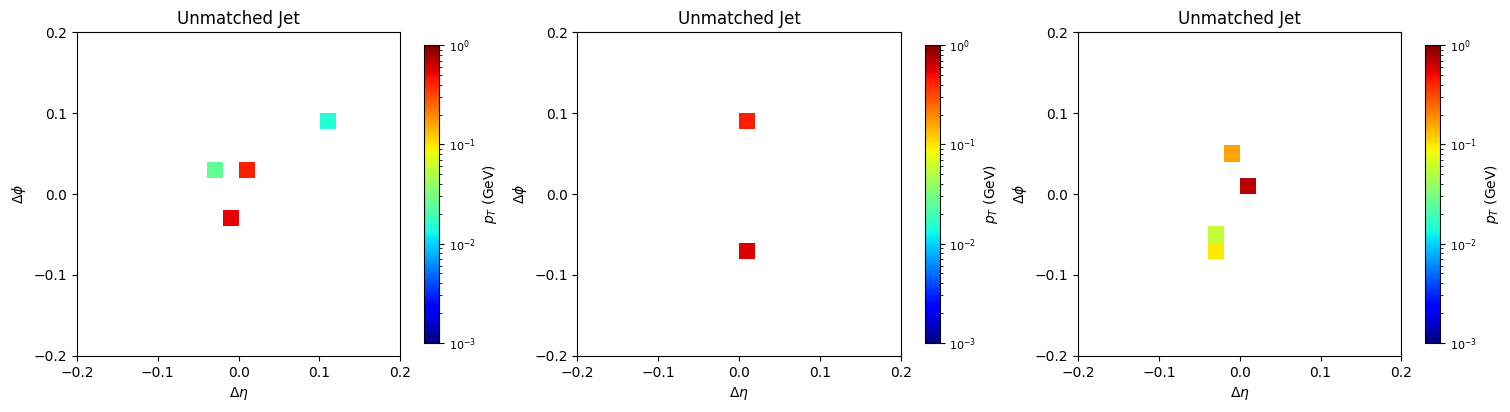


Processing batch: Events 10000 to 19999


Batch 10000: 100%|███████████████████████| 10000/10000 [00:18<00:00, 551.54it/s]


Saved batch 10000-19999 | Images: 17416 | Time: 18.19 sec


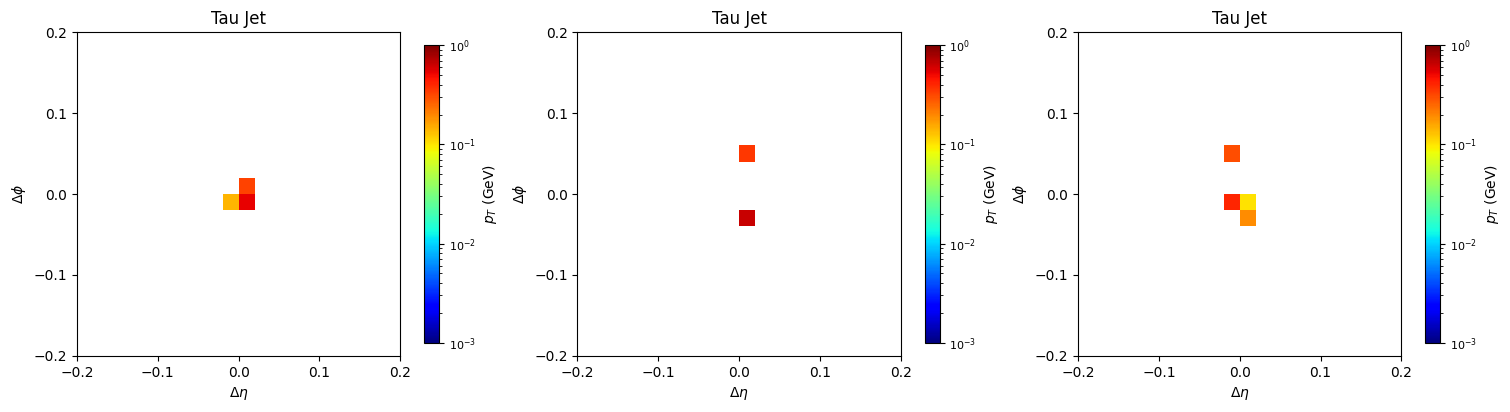

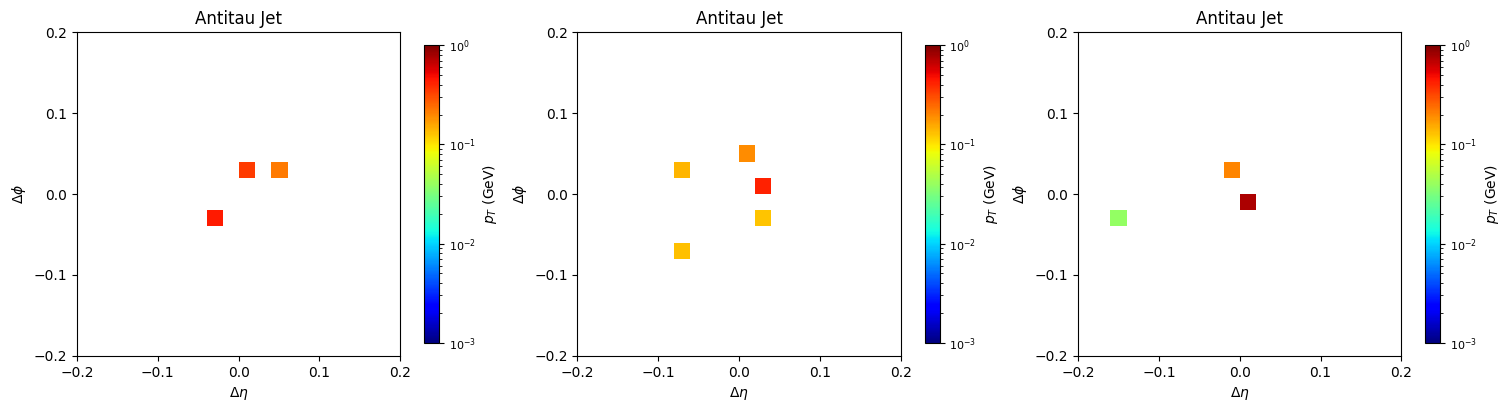

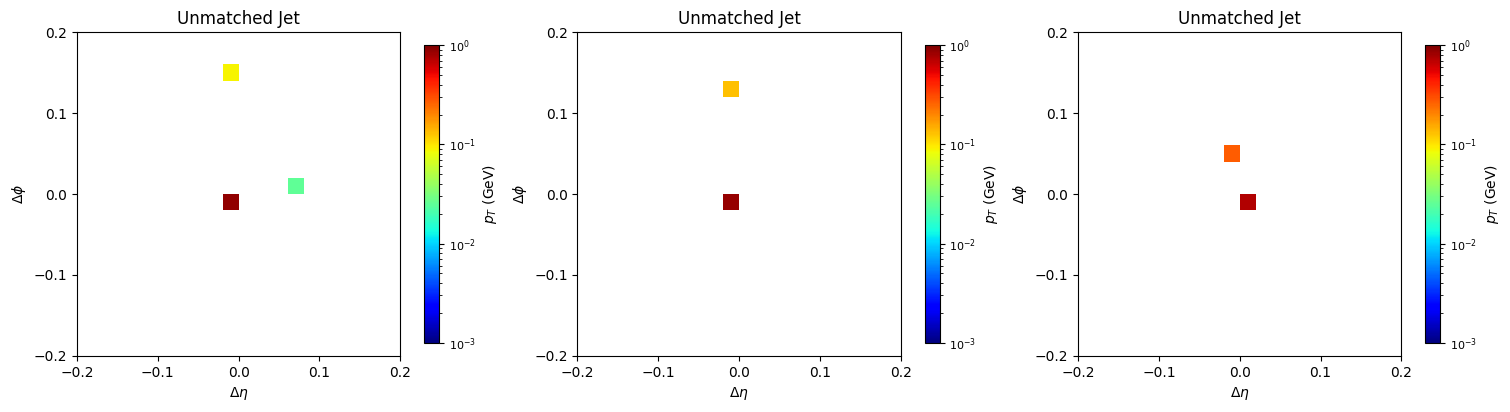


Processing batch: Events 20000 to 29999


Batch 20000: 100%|███████████████████████| 10000/10000 [00:17<00:00, 559.92it/s]


Saved batch 20000-29999 | Images: 17420 | Time: 17.91 sec


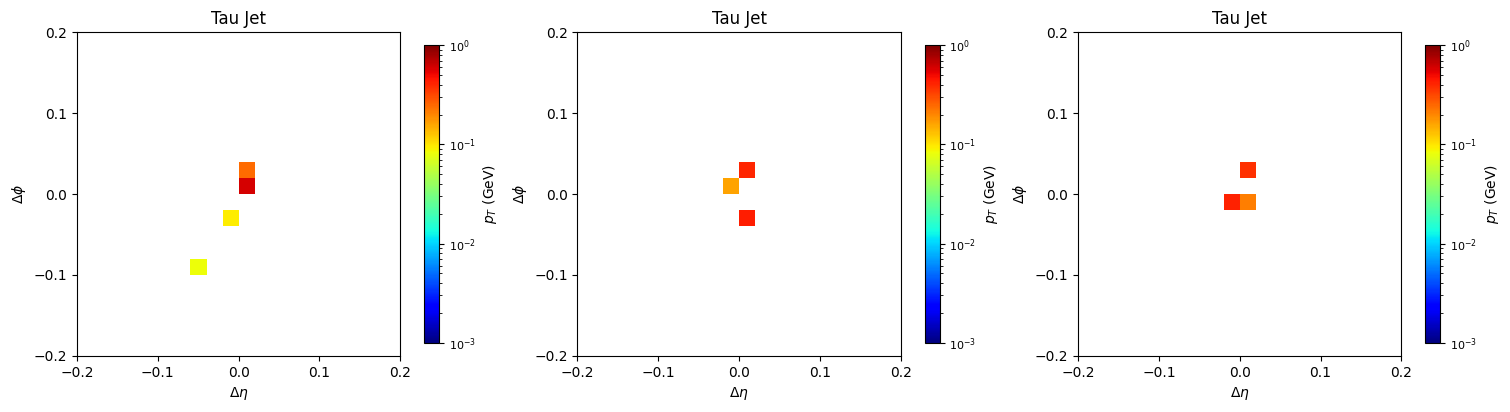

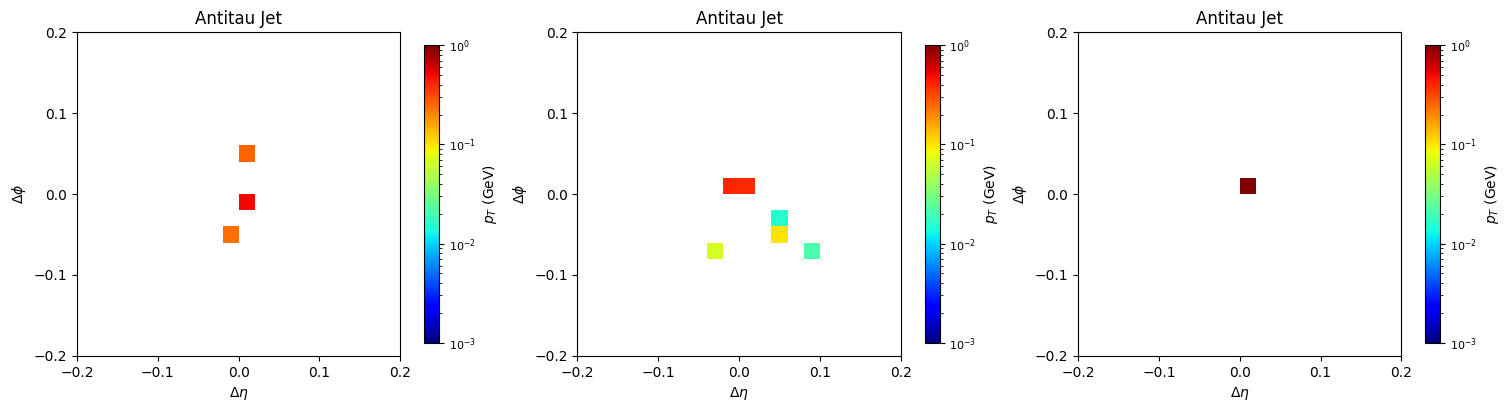

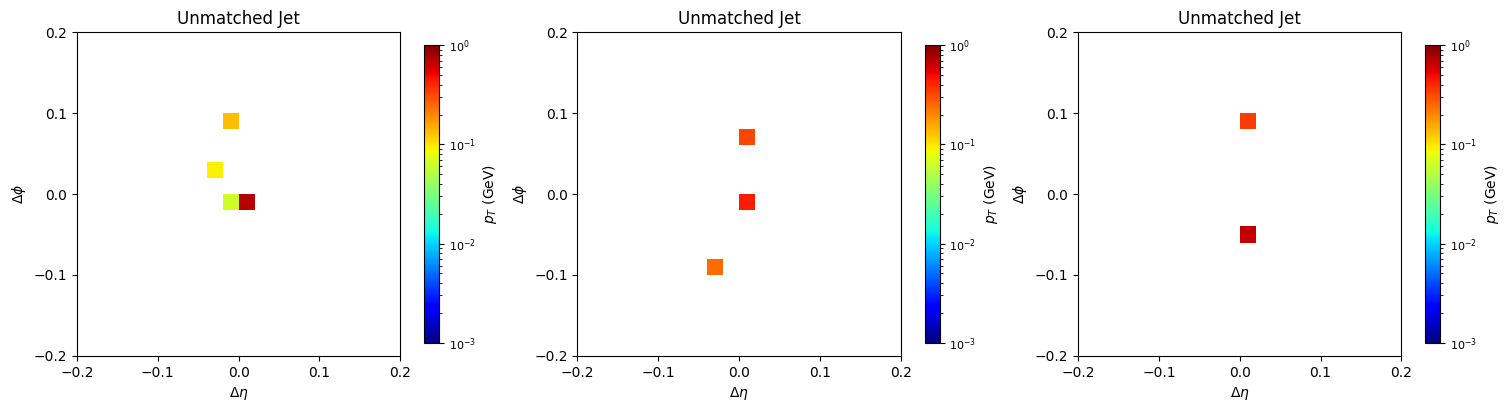


Processing batch: Events 30000 to 39999


Batch 30000: 100%|███████████████████████| 10000/10000 [00:17<00:00, 566.08it/s]


Saved batch 30000-39999 | Images: 17285 | Time: 17.72 sec


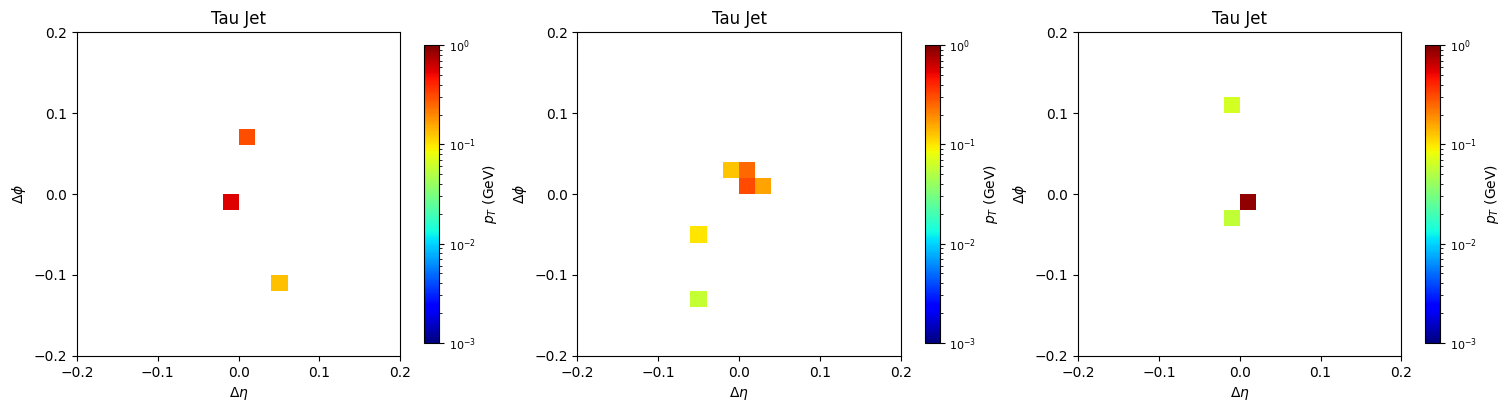

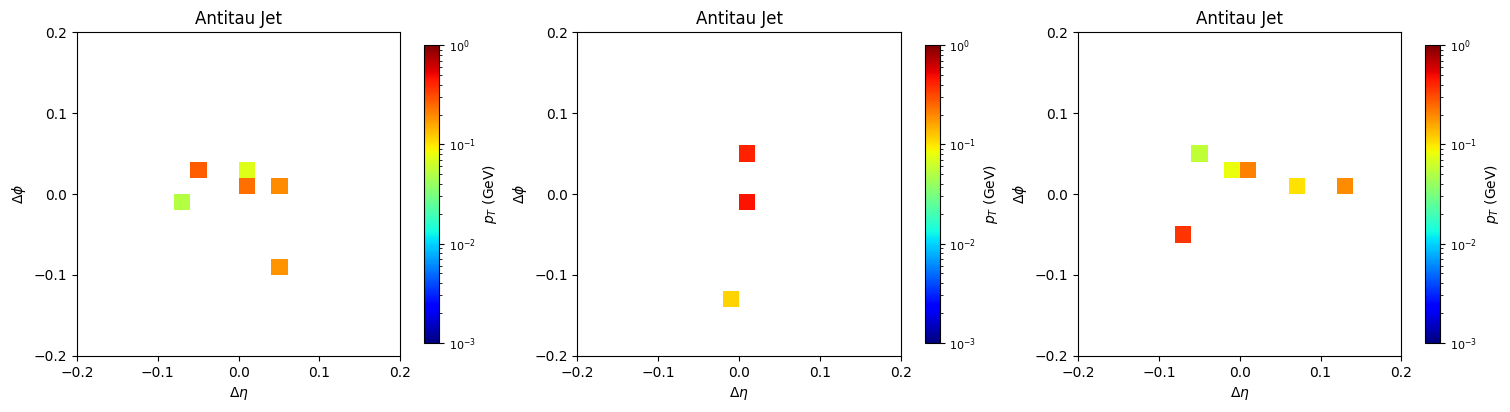

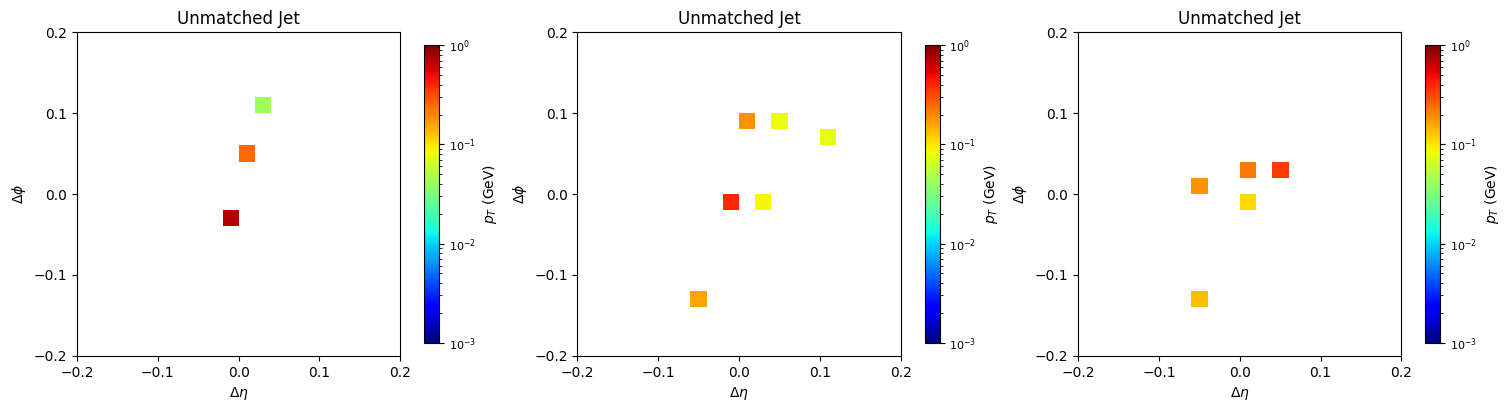


Processing batch: Events 40000 to 49999


Batch 40000: 100%|███████████████████████| 10000/10000 [00:17<00:00, 563.20it/s]


Saved batch 40000-49999 | Images: 17482 | Time: 17.80 sec


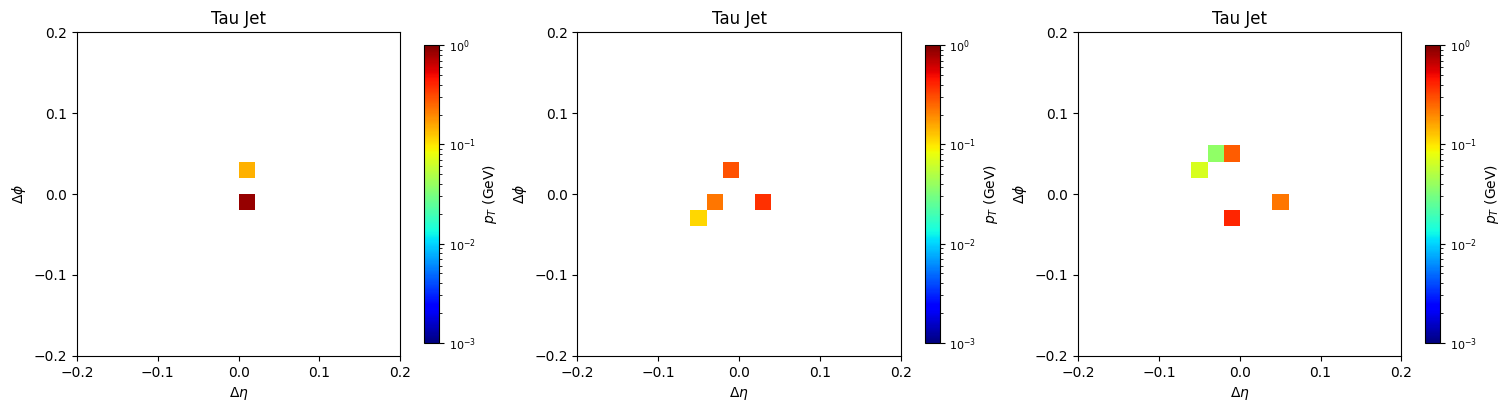

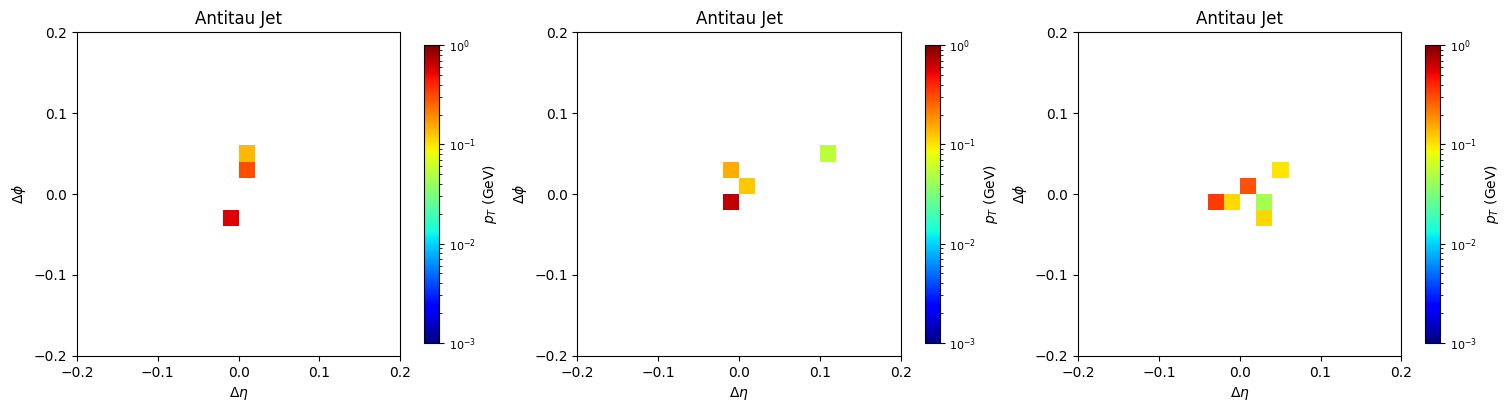

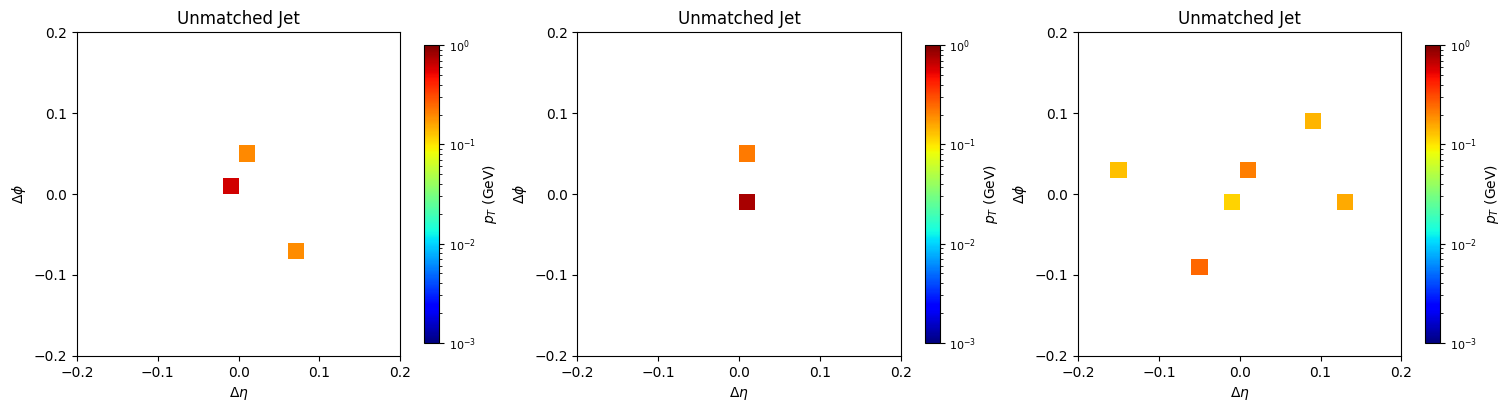


Processing batch: Events 50000 to 59999


Batch 50000: 100%|███████████████████████| 10000/10000 [00:17<00:00, 561.13it/s]


Saved batch 50000-59999 | Images: 17460 | Time: 17.87 sec


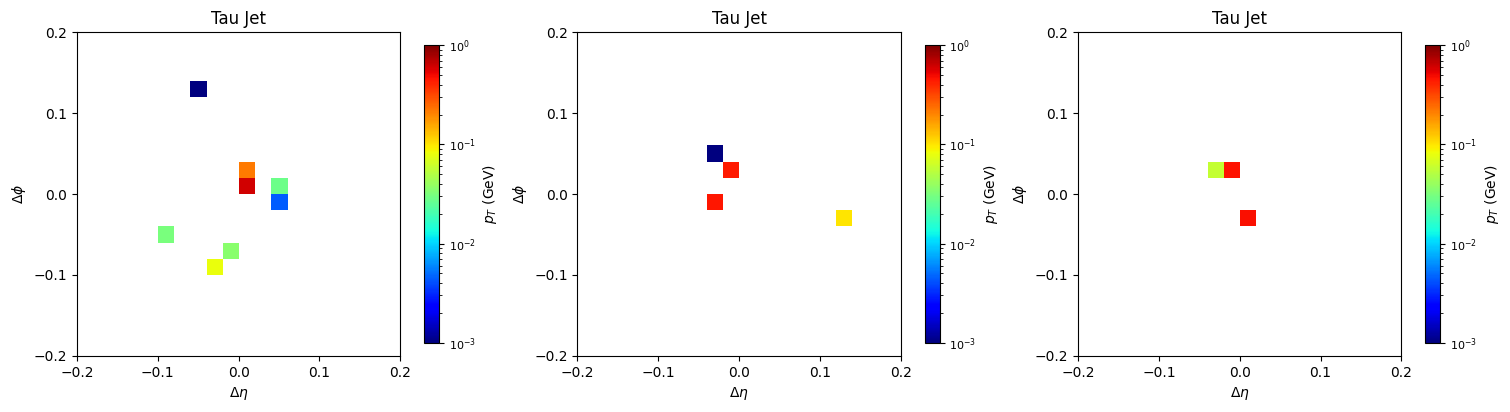

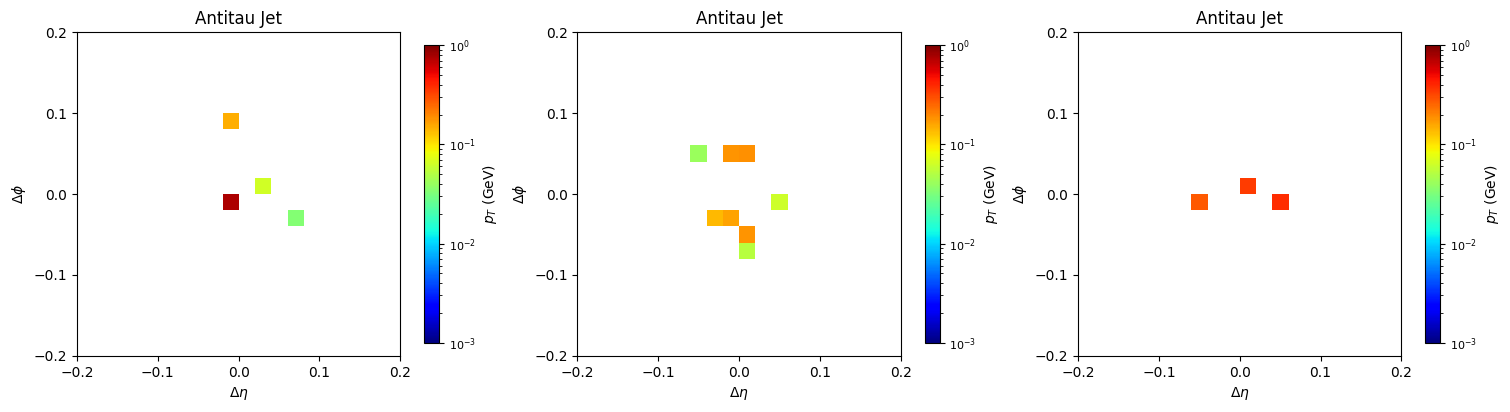

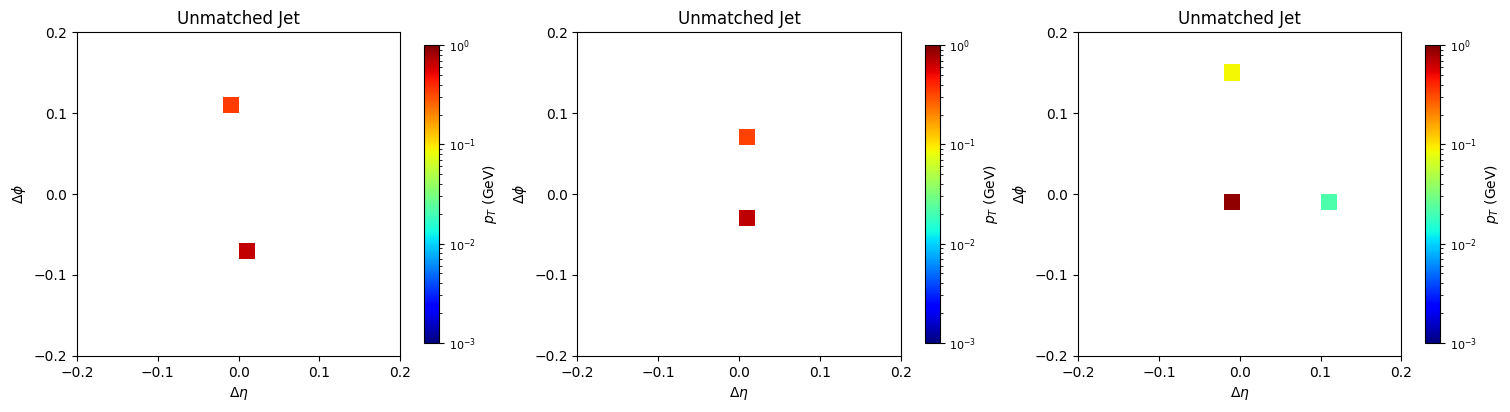


Processing batch: Events 60000 to 69999


Batch 60000: 100%|███████████████████████| 10000/10000 [00:17<00:00, 572.97it/s]


Saved batch 60000-69999 | Images: 17453 | Time: 17.50 sec


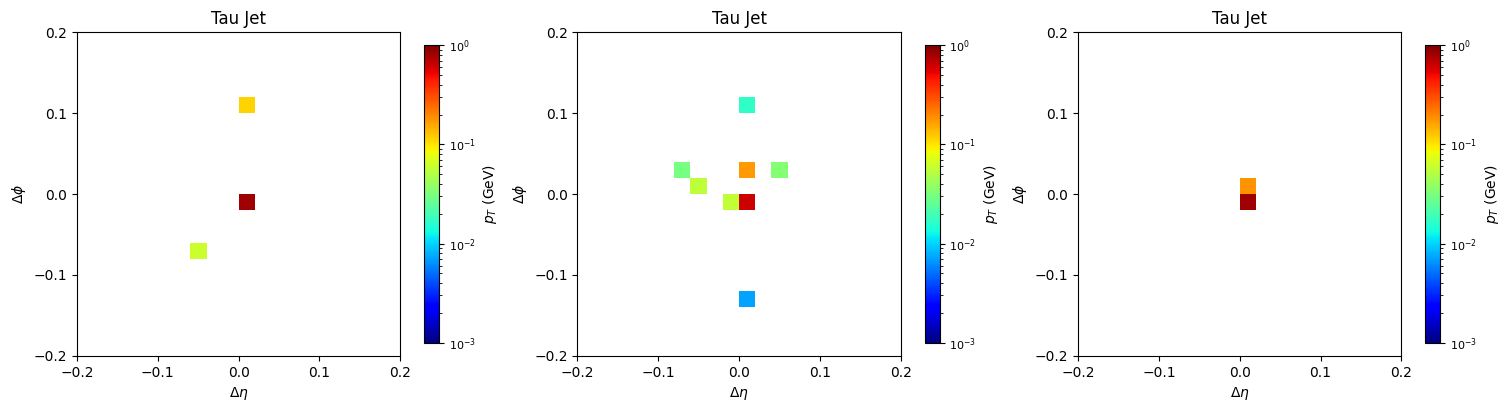

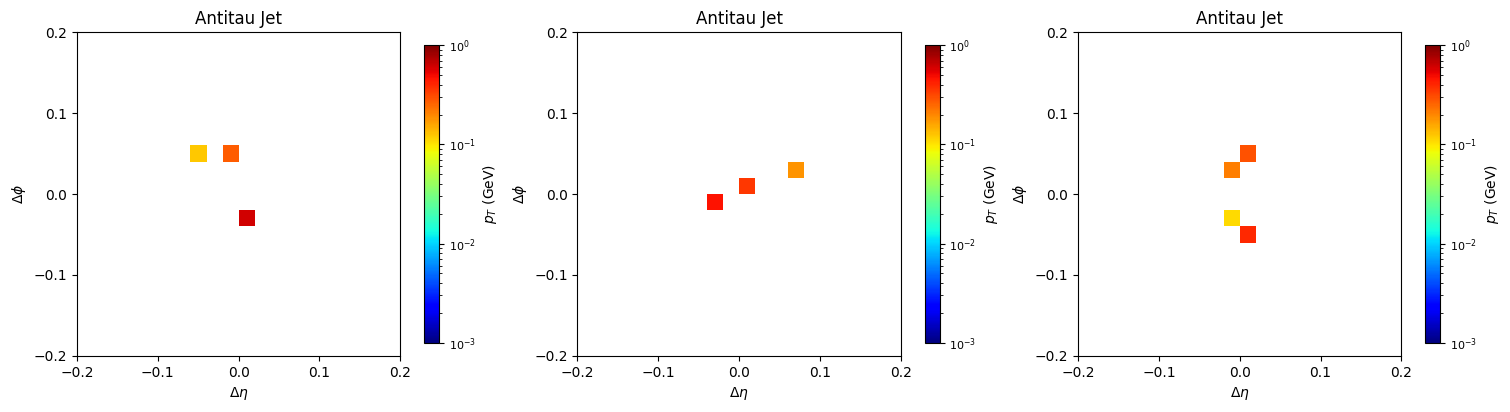

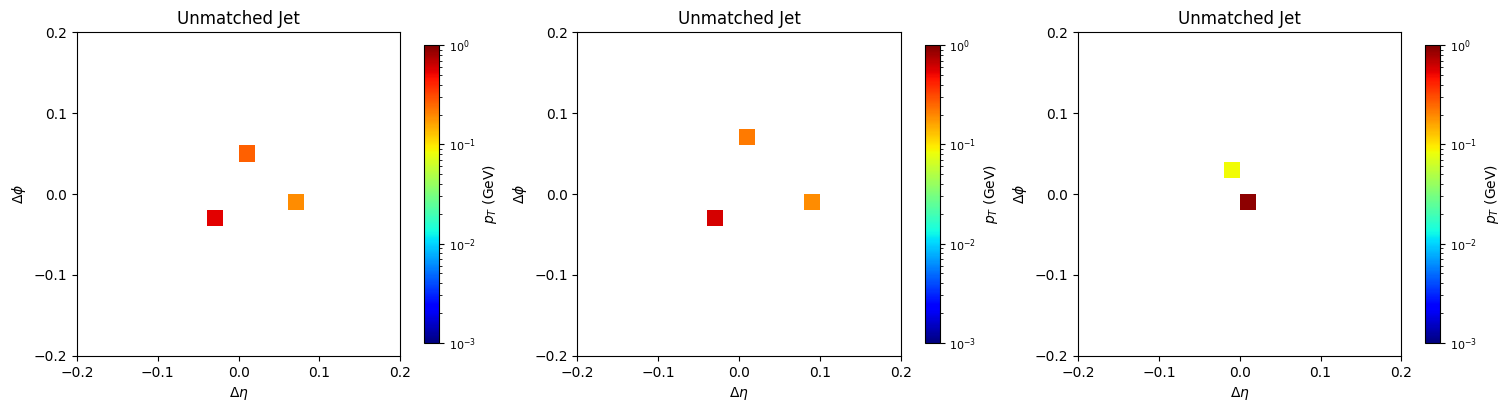


Processing batch: Events 70000 to 71414


Batch 70000: 100%|█████████████████████████| 1415/1415 [00:02<00:00, 568.38it/s]


Saved batch 70000-71414 | Images: 2451 | Time: 2.50 sec


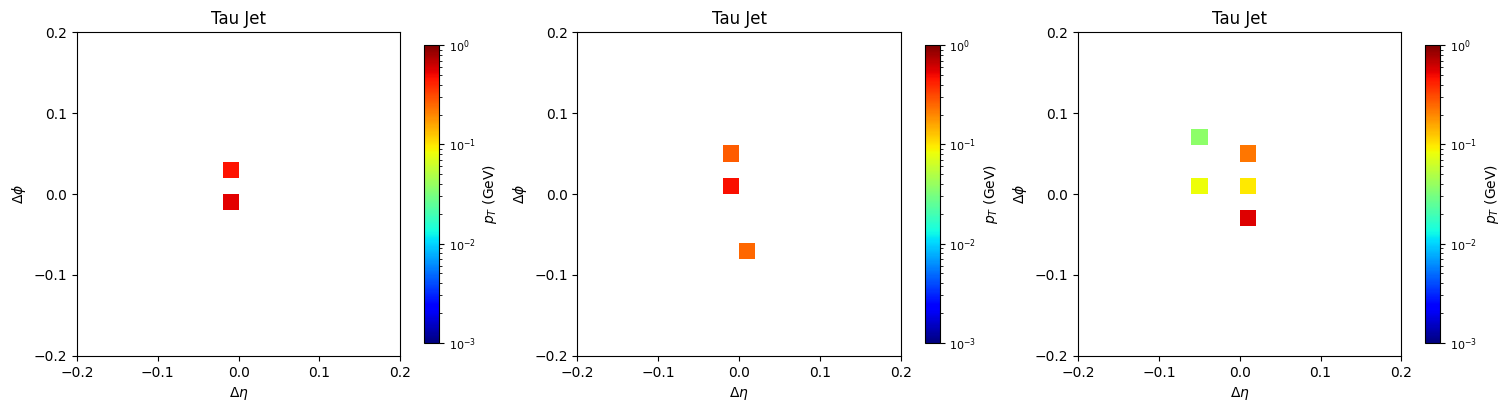

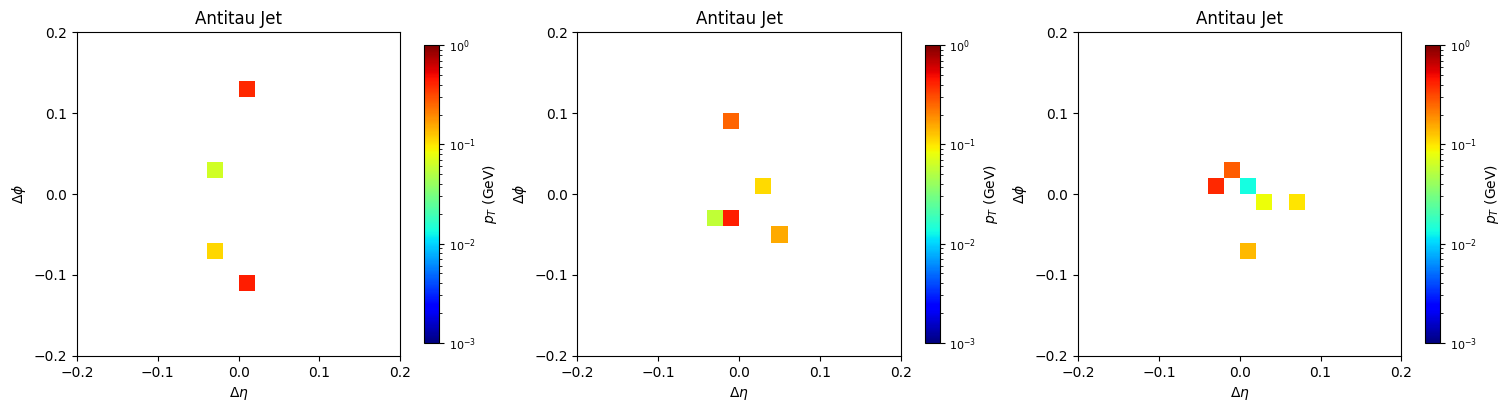

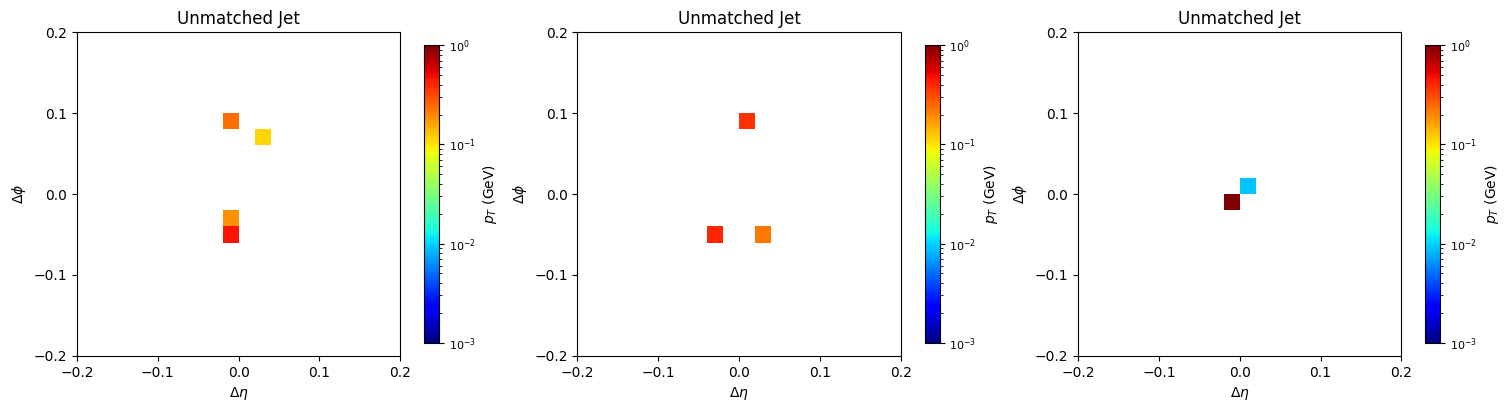

In [9]:
# ─── Process Core Jet Images in Batches from HDF5 ─────────────────────────────
with h5py.File(jet_data_path, "r") as f:
    total_events = len(f.keys())  # Total number of events in the dataset
    print(f"\nTotal events in dataset: {total_events}")

    # ─── Batch-wise Processing ────────────────────────────────────────────────
    for batch_start in range(0, total_events, BATCH_SIZE):
        batch_end = min(batch_start + BATCH_SIZE, total_events)

        # Initialize containers for core jet batch data
        batch_core_images = []
        batch_core_labels = []
        batch_core_pt_ratios = []
        batch_core_charged_ratios = []

        print(f"\nProcessing batch: Events {batch_start} to {batch_end - 1}")
        start_time = time.time()

        # ─── Loop Over Events in Current Batch ────────────────────────────────
        for i in tqdm(range(batch_start, batch_end), desc=f"Batch {batch_start}"):
            event = f[f"event_{i}"]
            num_jets = len(event["pt"])
            tags = [tag.decode("utf-8") for tag in event["tag"][:]]  # Decode jet tags
            pts = event["pt"][:]                                    # Jet pT values
            n_charged_all = event["charge_multiplicity"][:]         # Charged multiplicities

            # ─── Loop Over Jets in the Event ─────────────────────────────────
            for j in range(num_jets):
                label = tag_to_label.get(tags[j], 2)      # Map tag to label
                pt_jet = pts[j]                           # Jet pT
                total_charged = n_charged_all[j]          # Number of charged constituents
                constituents = event[f"jet_{j}_constituents"][:]  # Jet constituents

                # ─── Compute Core Region Properties ─────────────────────────
                core_pt_ratio, core_charged_ratio, core_mask = compute_core_ratios(
                    constituents, pt_jet, total_charged, jet_core_r
                )

                # Filter to retain only constituents within core radius
                core_constituents = constituents[core_mask]
                if len(core_constituents) == 0:
                    continue  # Skip if no core constituents

                # ─── Preprocess Core Jet: Center → Rotate → Image ───────────
                centered = center_jet(core_constituents)
                rotated = rotate_jet(centered)
                image = create_jet_image(
                    rotated, grids_core, eta_range_core, phi_range_core,
                    normalize=True
                )

                # ─── Store Valid Images and Metadata ────────────────────────
                if np.isclose(np.sum(image), 1.0, atol=1e-3):
                    batch_core_images.append(image)
                    batch_core_labels.append(label)
                    batch_core_pt_ratios.append(core_pt_ratio)
                    batch_core_charged_ratios.append(core_charged_ratio)

        # ─── Convert Lists to NumPy Arrays ───────────────────────────────────
        batch_core_images = np.array(batch_core_images, dtype=np.float32)
        batch_core_labels = np.array(batch_core_labels, dtype=np.int32)
        batch_core_pt_ratios = np.array(batch_core_pt_ratios, dtype=np.float32)
        batch_core_charged_ratios = np.array(batch_core_charged_ratios, dtype=np.float32)

        # ─── Save Core Jet Batch to Disk ─────────────────────────────────────
        np.save(core_jet_npy_file_path / f"core_images_batch_{batch_start}_taujet.npy", batch_core_images)
        np.save(core_jet_npy_file_path / f"core_labels_batch_{batch_start}_taujet.npy", batch_core_labels)
        np.savez(
            core_jet_npy_file_path / f"core_metadata_batch_{batch_start}_taujet.npz",
            core_pt_ratio=batch_core_pt_ratios,
            core_charged_ratio=batch_core_charged_ratios
        )

        # ─── Log Batch Processing Info ───────────────────────────────────────
        end_time = time.time()
        print(f"Saved batch {batch_start}-{batch_end - 1} | Images: {len(batch_core_images)} | Time: {end_time - start_time:.2f} sec")

        # ─── Plot Sample Images from the Batch ───────────────────────────────
        plot_sample_images(
            batch_core_images,
            batch_core_labels,
            tag_to_label,
            eta_range_core,
            phi_range_core,
            num_samples=3
        )